<center> <h1><b>Simple Search Engine with ML/DL</b></h1> </center>

# **1. Business Problem**

## **1.1 Problem Description/Statement**

There are various similar answers for a question and only one or few of them is correct. There are various online plateform where people come ask their question but they don't know whether the given answer by other people is correct or not. If this process is done manually, it'll be very money and time expensive. There are some onlie plateform which uses **Votes** on answer to order the answers given by people.

If a model can be made which can classify the given answer as correct/incorrect for the given question, it'll be great.

## **1.2 Sources**

> https://drive.google.com/file/d/1zo-WkF_R71JaCKBKf1jk0fVMV6ADEpmf/view?usp=sharing

> https://www.kaggle.com/christofhenkel/keras-baseline-lstm-attention-5-fold


## **1.3 Objective and Constraint**

**Objective**
* Classify the given answer as correct or incorrect for the given question.
* Get high **MRR** value for the model.

**Constraint**
* Chance of classifying as a correct answers when it is incorrect should be low.
* No strict latency constraint.


# **2. Machine Learning Problem**

## **2.1 Data**

### **2.1.1 Data Overview**

* There are total five columns in the dataset.

| column | description |
| :----: | :---------: |
| First  | this has question number|
| Second | this has question text|
| Third  | this has answer of the correspondig question|
| Fourth | this has answer label whether answer is correct or not (0 or 1)|
| Fifth  | this has answer label (0-9)|

* There are ten answers to each question and only one of them is correct.
* Correct answer has label **1** and incorrect answer has lebel **0**.
* The file size of this dataset is around 1.9 GB. 

## **2.2 Mapping the real world problem to a Machine Learning Problem**

### **2.2.1 Type of Machine Learning Problem**

For a given question and answer pair there is correct or incorrect possibility. So this is binary classification problem.

### **2.2.2 Performance metric**

**Primary**
* **MRR (mean reciprocal rank)** is primary metric.

**Secondary**
* Confusion matrix, Presion matrix, Recall Matrix.

**MRR**
* I will use [label_ranking_average_precision_score](https://scikit-learn.org/stable/modules/model_evaluation.html#label-ranking-average-precision) to calculate the **MRR**.
* Label ranking average precision (LRAP) averages over the samples the answer to the following question: for each ground truth label, what fraction of higher-ranked labels were true labels? This performance measure will be higher if you are able to give better rank to the labels associated with each sample. The obtained score is always strictly greater than 0, and the best value is 1. If there is exactly one relevant label per sample, label ranking average precision is equivalent to the [mean reciprocal rank (MRR)](https://en.wikipedia.org/wiki/Mean_reciprocal_rank).
* Formally, given a binary indicator matrix of the ground truth labels $ y \in \{0,1\}^{n_{samples}*n_{labels}} $ and the score associated with each label $ \hat{f} \in \mathbb{R}^{n_\text{samples} \times n_\text{labels}} $, the average precision is defined as 

$$LRAP(y, \hat{f}) = \frac{1}{n_{\text{samples}}}
  \sum_{i=0}^{n_{\text{samples}} - 1} \frac{1}{||y_i||_0}
  \sum_{j:y_{ij} = 1} \frac{|\mathcal{L}_{ij}|}{\text{rank}_{ij}}$$
* where $ \mathcal{L}_{ij} = \left\{k: y_{ik} = 1, \hat{f}_{ik} \geq \hat{f}_{ij} \right\} $, $ \text{rank}_{ij} = \left|\left\{k: \hat{f}_{ik} \geq \hat{f}_{ij} \right\}\right| $, $|\cdot| $ computes the cardinality of the set (i.e., the number of elements in the set), and $ ||\cdot||_0 $ is the $ \ell_0 $ 
 “norm” (which computes the number of nonzero elements in a vector).

>above content is taken from: https://scikit-learn.org/stable/modules/model_evaluation.html#label-ranking-average-precision

**Note** In our case there is only one correct answer for a question so it will return **MRR**. In our case $||y_i||_0$ and $ |\mathcal{L}_{ij}| $ will be always **1**, and equation $j$ will have only one possible value. So now this formula will become:
$$MRR (y, \hat{f}) = LRAP(y, \hat{f}) = \frac{1}{n_{\text{samples}}}
  \sum_{i=0}^{n_{\text{samples}} - 1} \Bigl(\frac{1}{\text{rank}_{ij}}\Bigr)_{j:y_{ij}=1}$$

### **2.2.3 Machine Learning Objective and Constraints**

**Objective**
* Given a question and answer pair, predict whether it is correct or in correct question.

**Constraint**
* To some extent Model interpretability is required.
* No latency constriant (but should not take more than minutes for a query point). 

# **3. Exploratory Data Analysis**

**Note:** **EDA** is based on whole dataset.

## **3.1 Data Loading**

In [0]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os, time, re, random, datetime
# https://stackoverflow.com/a/14463362/12005970
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from numpy import asarray
import pandas as pd
from scipy.sparse import coo_matrix, hstack, load_npz, save_npz
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import pickle

from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn import model_selection
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from prettytable import PrettyTable

In [0]:
d = "/content/drive/My Drive/Colab Notebooks/Datasets/Personal Case Study/Search Engine/"
df = pd.read_csv(d+"data.tsv", sep = "\t", header = None, low_memory = True)
col_names = ["que_no", "question", "answer", "label", "ans_no"]
print("Before number column in dataset are : ", df.shape[1])
df.columns = col_names
# Note: que_no column is not useful for this probelm, so I'm droping this column
df.drop(["que_no", "ans_no"], axis = 1, inplace = True)
print("After droping number columns in dataset are: ", df.shape[1])
print("Number of datapoints in dataset : {:,}".format(df.shape[0]))
print("\n",df.dtypes)
print("\n\n")
df.head(20)

Before number column in dataset are :  5
After droping number columns in dataset are:  3
Number of datapoints in dataset : 5,241,880

 question    object
answer      object
label        int64
dtype: object





question  ... label
0    . what is a corporation?  ...     0
1    . what is a corporation?  ...     0
2    . what is a corporation?  ...     0
3    . what is a corporation?  ...     0
4    . what is a corporation?  ...     0
5    . what is a corporation?  ...     1
6    . what is a corporation?  ...     0
7    . what is a corporation?  ...     0
8    . what is a corporation?  ...     0
9    . what is a corporation?  ...     0
10  symptoms of a dying mouse  ...     0
11  symptoms of a dying mouse  ...     0
12  symptoms of a dying mouse  ...     0
13  symptoms of a dying mouse  ...     0
14  symptoms of a dying mouse  ...     0
15  symptoms of a dying mouse  ...     1
16  symptoms of a dying mouse  ...     0
17  symptoms of a dying mouse  ...     0
18  symptoms of a dying mouse  ...     0
19  symptoms of a dying mouse  ...     0

[20 rows x 3 columns]

## **3.2 Text Pre-processing**

In [0]:
ques = df["question"].unique()
ans  = df["answer"].unique()

for i in range(7):
    print("Question: {}".format(ques[i]))
    print("Answer: {}".format(ans[i]))

Question: . what is a corporation?
Answer: A company is incorporated in a specific nation, often within the bounds of a smaller subset of that nation, such as a state or province. The corporation is then governed by the laws of incorporation in that state. A corporation may issue stock, either private or public, or may be classified as a non-stock corporation. If stock is issued, the corporation will usually be governed by its shareholders, either directly or indirectly.
Question: symptoms of a dying mouse
Answer: Today, there is a growing community of more than 2,100 Certified B Corps from 50 countries and over 130 industries working together toward 1 unifying goal: to redefine success in business. Join the Movement
Question: average number of lightning strikes per day
Answer: Corporation definition, an association of individuals, created by law or under authority of law, having a continuous existence independent of the existences of its members, and powers and liabilities distinct fr

**After looking at these sentences**
 * I'll do **stopword** removal (except **NOT** and question words)
 * I'll remove extrac spaces and special symbals, emojis.
 * I'll expand words  like **I'll to I will**, **"I'm to I am"** etc.
 * I'll remove html tags if it exist.


In [0]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
try:
    stop_words = set(stopwords.words("english"))
except:
    nltk.download('stopwords')
    stop_words = set(stopwords.words("english"))

#removing "not" stop word from stop_words
stop_words = stop_words - {"not", "what", "when", "where", "how", "which","why"}

In [0]:
##########################################################################################################
#################################### function to pre-process the text ####################################
##########################################################################################################
def text_process(row):
    """
    this function is for pre-processing the text.
    exppand the sentences, remove stopwords, removes html, remove extra space etc.
    """
    try:
        text = row
        text = str(text).lower()
        porter = PorterStemmer()
        #expansion
        text = text.replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
        .replace("n't", " not").replace("what's", "what is").replace("it's", "itis")\
        .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
        .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
        .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar")\
        .replace("€", " euro ").replace("'ll", " will")
        text = re.sub(r"<.*?>","", text) # removes the htmltags: https://stackoverflow.com/a/12982689
        #special character removal
        text = re.sub('[^a-zA-Z0-9\n]', ' ', text)
        #extra space removal
        text = re.sub('\s+',' ', text)
        # stopword removal
        text_to_words = []
        for word in text.split():
            if word not in stop_words:
                text_to_words.append(word)
            else:
                continue
        text = " ".join(text_to_words)
        return text
    except:
        print("There is no value in comment_text, so returnin 'nan'")
        return np.nan

In [0]:
tic = time.time()
print("text processing...")
print(" for questions...")
df.loc[:,"question"] = df["question"].apply(text_process)
print(" for answers...")
df.loc[:,"answer"] = df["answer"].apply(text_process)
print("Time take to process the text data: {:.2f} seconds".format(time.time()-tic))

text processing...
 for questions...
 for answers...
Time take to process the text data: 392.31 seconds


## **3.3 Basic Analysis**

### **3.3.1 Number of `NaN`s in dataset**

In [0]:
print(df.isna().sum())

question    0
answer      0
label       0
dtype: int64


* There are no `NaN` values in dataet.
* But there are some questions and answeres where no text is available, so let's see them.
* There are some row where questions are as `null` as string and they can't be detected using `pd.isna()`.
* Let's see them and drop them. 

In [0]:
len_q = [len(i) for i in df["question"]]
len_a = [len(i) for i in df["answer"]]

q,a = [], []
for i in range(len(len_q)):
    if len_q[i] == 0:
        q.append(i)
    if len_a[i] == 0:
        a.append(i)

aa = []
for i, text in enumerate(df["question"]):
    if text == 'null':
        aa.append(i)

In [0]:
# where no questions are present
df.iloc[q, :]

question                                             answer  label
1047272                                              allows control      0
1047273           different ways control phone number format rec...      0
1047274           phone number address date link colors when ios...      0
1047275           understanding phone number detection when inte...      0
1047276           dear business partner welcome brand new websit...      0
1047277           applelinksgrey color 9a9a9a important text dec...      0
1047278           little bit cleaner version ie edge accomplish ...      1
1047279           website taxonomy improve classification search...      0
1047280           usage 0001 example user id v0 7 identifies whi...      0
1047281                                                  page title      0

In [0]:
# where no answer are present
df.iloc[a, :]

question answer  label
139667                   kathleen crowley esq             0
162641   attorney mikell wyman south carolina             0
162643   attorney mikell wyman south carolina             0
162644   attorney mikell wyman south carolina             0
162646   attorney mikell wyman south carolina             0
659615                        what state nick             0
1304046                          stephen nunn             0
1363965                   jennifer lee taylor             0
1363966                   jennifer lee taylor             0
1533971        implementation plan definition             0
1541593                leaning tower pisa art             0
1541594                leaning tower pisa art             0
1720077                        ride bike help             0
2192781         how many states united states             0
2281294               elizabeth blackwell fff             0
2468953                  where fredericksburg             0
2809645       aroza sanjana cell phone number             0
2887313                  where john persinger             0
2887321                  where john persinger             0
3304728                      rhonda pomerantz             0
3304730                      rhonda pomerantz             0
3304732                      rhonda pomerantz             0
4000754                            what gayot             0
4715018                         breana mackey             0
4715020                         breana mackey             0
4715022                         breana mackey             0
4715023                         breana mackey             0
4715027                         breana mackey             0

In [0]:
# questions as `null` string
df.iloc[aa,:]

question                                             answer  label
4814988     null  back vengeance gwen sent null void max using n...      0
4814989     null  case null file not open highly likely not corr...      0
4814990     null  null exploit one result infinite bux relies ga...      0
4814991     null  note important understand null value different...      0
4814992     null  null tiny tower memory state exploited grant p...      0
4814993     null  back vengeance kevin 11 imprisoned null void m...      0
4814994     null  unfortunately nobody told what null null value...      0
4814995     null  stephen barrett gary michael null 1945 one nat...      1
4814996     null  what null value field null value field value f...      0
4814997     null  null often refers common view something altern...      0

* Let's drop these rows.

In [0]:
# relacing such question and answers with np.Nan and then droping them
df.replace(["", "null"], np.nan, inplace = True)
df.dropna(axis = 0, how = "any", inplace= True)

In [0]:
len_q = [len(i) for i in df["question"]]
len_a = [len(i) for i in df["answer"]]

q,a = [], []
for i in range(len(len_q)):
    if len_q[i] == 0:
        q.append(i)
    if len_a[i] == 0:
        a.append(i)

aa = []
for i, text in enumerate(df["question"]):
    if text == 'null':
        aa.append(i)

print(df.iloc[q, :])
print(df.iloc[a, :])
print(df.iloc[aa, :])

Empty DataFrame
Columns: [question, answer, label]
Index: []
Empty DataFrame
Columns: [question, answer, label]
Index: []
Empty DataFrame
Columns: [question, answer, label]
Index: []


* It is clear from above cell output that, I've dropped them.

### **3.2.2 Number of unique Questions/Answers**

In [0]:
print("Number of unique questions on the dataset is {:,}\
 out of {:,} questions i.e. {:.3f}%".format(len(df['question'].unique()), df.shape[0],
                                           100*len(df['question'].unique())/df.shape[0]))
print("Number of unique questions on the dataset is {:,}\
 out of {:,} answers i.e. {:3f}%".format(len(df['answer'].unique()), df.shape[0],
                                        100*len(df['answer'].unique())/df.shape[0]))

Number of unique questions on the dataset is 510,136 out of 5,241,832 questions i.e. 9.732%
Number of unique questions on the dataset is 4,706,060 out of 5,241,832 answers i.e. 89.778917%


### **3.3.3 Number of `duplicates` rows**

In [0]:
print("Number of duplicate rows in dataset: \
{:,}".format(len(df)-len(df.drop_duplicates(subset = ["question", "answer"],keep = False))))

Number of duplicate rows in dataset: 67,478


* There are **64,478** duplicate rows in the dataset.
* Drop all dulicate rows in the dataset.

In [0]:
print("Before droping dulicated number of datapoints = {:,}".format(len(df)))
df.drop_duplicates(subset = ["question", "answer"], keep = False, inplace = True)
df.reset_index(inplace=True,drop=True)
print("After droping dulicated number of  datapoints = {:,}".format(len(df)))

Before droping dulicated number of datapoints = 5,241,832
After droping dulicated number of  datapoints = 5,174,354


### **3.3.4 Answer per Question**

After droping rows in above section there will be some questions which will not 10 answers.
* If question has more than 1 correct answer drop it.
* If such question does not have correct answer drop it.
* If such question has only one correct and no incorrect answer drop it.
* If question has one correct answer and less than 9 incorrect answer, to make 10 answer per question repeat any incorrect answer randomly.

In [0]:
ques = df["question"].unique()
print('Number of unique questions in dataset are: {}\n\
and lengt of df is: {:,}\n\
But {:,}*10= {:,} != {:,}'.format(len(ques), len(df), len(ques), 10*len(ques), len(df)))

Number of unique questions in dataset are: 524188
and lengt of df is: 5,174,354
But 524,188*10= 5,241,880 != 5,174,354


From above it is clear that there are some rows which do not have exactly 10 answers.

**Let's remove the questions that have more than 1 correct answer**

In [0]:
# https://stackoverflow.com/a/43501282/12005970
a = df.groupby('question')\
    .agg({'label': 'sum'})\
    .reset_index()\
    .rename(columns={'label': 'correct answers'})
# questions that have more than 1 correct answer
multiple_correct_answers_df = a[a['correct answers']>1]
multiple_correct_answers_df.head(10)

question  correct answers
348                     401k ira                2
602                         abba                3
886         abundant element sun                2
900        abundant protein body                2
1647          actress commercial                2
1739  actress plays wonder woman                2
1792  acupuncture relieve stress                2
1865                        adam                2
1883            adam levine wife                2
1892                  adam smith                2

In [0]:
print('Number questions that have more than 1 correct answers: {:,}'.format(len(multiple_correct_answers_df)))
# getting the questions that have more than 1 correct answer
multiple_correct_answers = multiple_correct_answers_df['question'].values
# dropping such questions
print('number of rows before dropping questions more than 1 correct answer is: {:,}'.format(len(df)))
df.drop(df[df['question'].isin(multiple_correct_answers)].index, axis = 0, inplace=True)
df.reset_index(inplace=True, drop= True)
print('number of rows after dropping questions more than 1 correct answer is: {:,}'.format(len(df)))

Number questions that have more than 1 correct answers: 9,819
number of rows before dropping questions more than 1 correct answer is: 5,174,354
number of rows after dropping questions more than 1 correct answer is: 4,971,431


**Questions that don't have correct answer**

In [0]:
a = df.groupby('question')\
    .agg({'label': 'sum'})\
    .reset_index()\
    .rename(columns={'label': 'correct answers'})
# questions that have more than 1 correct answer
no_correct_answers_df = a[a['correct answers'] == 0]
no_correct_answers_df.head(10)

question  correct answers
120      16th amendment legally ratified                0
195   2005 pontiac vibe anti lock brakes                0
321        350 degree fahrenheit celsius                0
340                         40 inch foot                0
361                 453 50 convert icd10                0
517                 aaa toll free number                0
714          abiogenesis scientific name                0
721               abiotic factors humans                0
974                  acceleration vector                0
1002    access bank texas routing number                0

In [0]:
print('Number questions that do not have correct answers: {:,}'.format(len(no_correct_answers_df)))
# getting the questions that don't have correct answers
no_correct_answers = no_correct_answers_df['question'].values
# dropping such questions
print('number of rows before dropping questions than do not have correct answer is: {:,}'.format(len(df)))
df.drop(df[df['question'].isin(no_correct_answers)].index, axis = 0, inplace=True)
df.reset_index(inplace=True, drop= True)
print('number of rows after dropping questions that do not correct answer is: {:,}'.format(len(df)))

Number questions that do not have correct answers: 4,488
number of rows before dropping questions than do not have correct answer is: 4,971,431
number of rows after dropping questions that do not correct answer is: 4,934,335


**Questions that have only one correct and no incorrect**

In [0]:
a = df.groupby('question')\
    .agg({'answer': 'count', 'label': 'sum'})\
    .reset_index()\
    .rename(columns={'answer':'total answers', 'label': 'correct answers'})
# questions that have only no incorrect answer and 
one_correct_no_incorrect_answers_df = a[(a['correct answers'] == 1) & (a['total answers'] == 1)]
one_correct_no_incorrect_answers_df.head()

Empty DataFrame
Columns: [question, total answers, correct answers]
Index: []

* There are no such questions that have only 1 answer and no incorrect answer.
* Now in the dataset all question has 1 correct answer and 1 or more incorrect answer. 

**Questions that don't have 10 answers**

In [0]:
a = df.groupby('question')\
    .agg({'answer': 'count'})\
    .reset_index()\
    .rename(columns={'answer':'total answers'})
# questions that have only no incorrect answer and 
less_than_10_answers_df = a[a['total answers'] < 10]
less_than_10_answers_df.head()

question  total answers
6   1 1 identify how infections spread              8
12           1 5 miles how many metres              8
23                        1 cup ounces              8
49        1 what name fort ship island              8
87                            130 g oz              6

In [0]:
print('Number questions that have less than 10 answers is: {:,}'.format(len(less_than_10_answers_df)))
# getting the questions that have less than 10 answers
less_than_10_answers = less_than_10_answers_df['question'].values
# dropping such questions
print('number of rows before dropping questions that have less than 10 answers is: {:,}'.format(len(df)))
df.drop(df[df['question'].isin(less_than_10_answers)].index, axis = 0, inplace=True)
df.reset_index(inplace=True, drop= True)
print('number of rows after dropping questions that have less than 10 answers is: {:,}'.format(len(df)))

Number questions that have less than 10 answers is: 13,595
number of rows before dropping questions that have less than 10 answers is: 4,934,335
number of rows after dropping questions that have less than 10 answers is: 4,828,383


In [0]:
a = df.groupby('question')\
    .agg({'answer': 'count'})\
    .reset_index()\
    .rename(columns={'answer':'total answers'})
# questions that have only no incorrect answer and 
greater_than_10_answers_df = a[a['total answers'] > 10]
greater_than_10_answers_df.head()

question  total answers
93    14th amendment due process clause             14
3422               age shingles vaccine             18
7848              appoints director fbi             16
8655                     artist cut ear             22
9673        australia continent country             14

In [0]:
print('Number questions that have greater than 10 answers is: {:,}'.format(len(greater_than_10_answers_df)))
# getting the questions that have greater than 10 answers
greater_than_10_answers = greater_than_10_answers_df['question'].values
# dropping such questions
print('number of rows before dropping questions that have greater than 10 answers is: {:,}'.format(len(df)))
df.drop(df[df['question'].isin(greater_than_10_answers)].index, axis = 0, inplace=True)
df.reset_index(inplace=True, drop= True)
print('number of rows after dropping questions that have greater than 10 answers is: {:,}'.format(len(df)))

Number questions that have greater than 10 answers is: 924
number of rows before dropping questions that have greater than 10 answers is: 4,828,383
number of rows after dropping questions that have greater than 10 answers is: 4,812,950


**Note:** Above process can be done one single line by writing all condition all together with **or** operator.

## **3.4 Distribution of `labels`**

In [0]:
fig, ax1 = plt.subplots(1,1, figsize =(6,6))
ax1.set_title('Distribution of label over whole dataset', fontsize=15)
sns.countplot(df["label"], ax = ax1)
ax1.set_xlabel("target", fontsize = 12)
ax1.set_ylabel("count", fontsize = 12)

for p in ax1.patches:
    ax1.annotate('{:.0f}%'.format(p.get_height()*100/len(df)), 
                (p.get_x()+0.25, p.get_height()+1), fontsize=12)
    # to chnage the annotate font size:  https://matplotlib.org/3.1.1/tutorials/text/text_intro.html

plt.show()

* For each question there are ten answers, that's why it look like this.

## **3.5 Hand Crafted Features**

I'm going to design some features using text data of question and answer.

| S.N. | Hand Crfated Feature Name | Description |
| :--: | :-----------------------: | :---------: |
| 1.   | que_len | total lenght of question |
| 2.   | ans_len | total lenght of answer |
| 3.   | que_word | number of words in question |
| 4.   | ans_word | number of words in answer |
| 5.   | unique_word_que | number of unique words in question |
| 6.   | unique_word_ans | number of unique word in answer |
| 7.   | ratio_q_a_len | ratio of que_len to ans_len |
| 8.   | ratio_q_a_word | ratio of que_word to ans_word |
| 9.   | ratio_q_a_unique_word| ratio of unique_word_que to unique_word_ans |
| 10.  | ration_qword_alen | ratio of que_word to ans_len |
|11. | ratio_aword_qlen | ratio of ans_word to que_len|
| 12.| ratio_unique_qword_aword | ratio of unique_word_que to ans_word |
| 13.  | ratio_unique_aword_qword | ratio of unique_word_ans to que_word|


In [0]:
##########################################################################################################
#################################### function to design the features  ####################################
##########################################################################################################

def hand_craft_features(data_df):
    """
    this creates the hand crafted features.
    """
    # lenth features
    data_df["que_len"] = data_df["question"].apply(lambda x:len(x))
    data_df["ans_len"] = data_df["answer"].apply(lambda x:len(x))
    data_df["que_word"] = data_df["question"].apply(lambda x:len(x.split()))
    data_df["ans_word"] = data_df["answer"].apply(lambda x:len(x.split()))
    data_df["unique_word_que"] = data_df["question"].apply(lambda x:len(set(x.split())))
    data_df["unique_word_ans"] = data_df["answer"].apply(lambda x:len(set(x.split())))
    #ratio features
    data_df["ratio_q_a_len"] = data_df["que_len"]/data_df["ans_len"]
    data_df["ratio_q_a_word"] = data_df["que_word"]/data_df["ans_word"]
    data_df["ratio_q_a_unique_word"] = data_df["unique_word_que"]/data_df["unique_word_ans"]
    data_df["ration_qword_alen"] = data_df["que_word"]/data_df["ans_len"]
    data_df["ratio_aword_qlen"] = data_df["ans_word"]/data_df["que_len"]
    data_df["ratio_unique_qword_aword"] = data_df["unique_word_que"]/data_df["ans_word"]
    data_df["ratio_unique_aword_qword"] = data_df["unique_word_ans"]/data_df["que_word"]
 
    df.replace([np.inf], np.nan, inplace = True)
    data_df.fillna(0, inplace=True)
    
    return data_df

In [0]:
d = "/content/drive/My Drive/Colab Notebooks/Datasets/Personal Case Study/Search Engine/"
if  os.path.isfile(d+"Processed Data/text_processed.csv"):
    print("loading text processed .csv file from the disk...")
    df = pd.read_csv(d+"Processed Data/text_processed.csv", low_memory= True)
else:
    tic = time.time()
    print("\nDesigning new features...")
    df = hand_craft_features(df)
    print("Done!")
    print("time taken to hand craft the features: {:.4f} seconds".format(time.time()-tic))
    print("\nSaving data into disk...")
    df.sort_values(by = ['question'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df.to_csv(d+"Processed Data/text_processed.csv", index = False)

loading text processed .csv file from the disk...


In [0]:
ques = df["question"].unique()
print('Number of unique questions in dataset are: {}\n\
and lengt of df is: {:,}\n\
But {:,}*10= {:,} == {:,}'.format(len(ques), len(df), len(ques), 10*len(ques), len(df)))

Number of unique questions in dataset are: 481295
and lengt of df is: 4,812,950
But 481,295*10= 4,812,950 == 4,812,950


## **3.6 EDA on Hand Crafted Features**

### **3.6.1 Univariate Analysis**

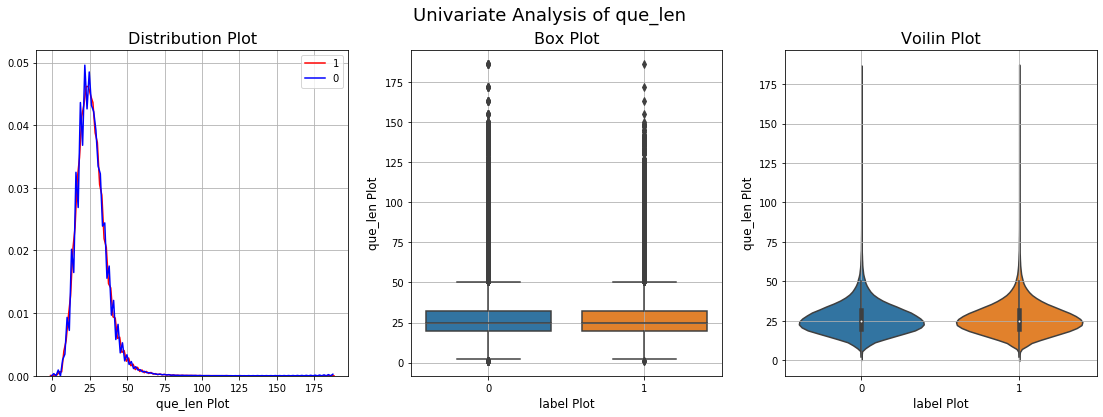

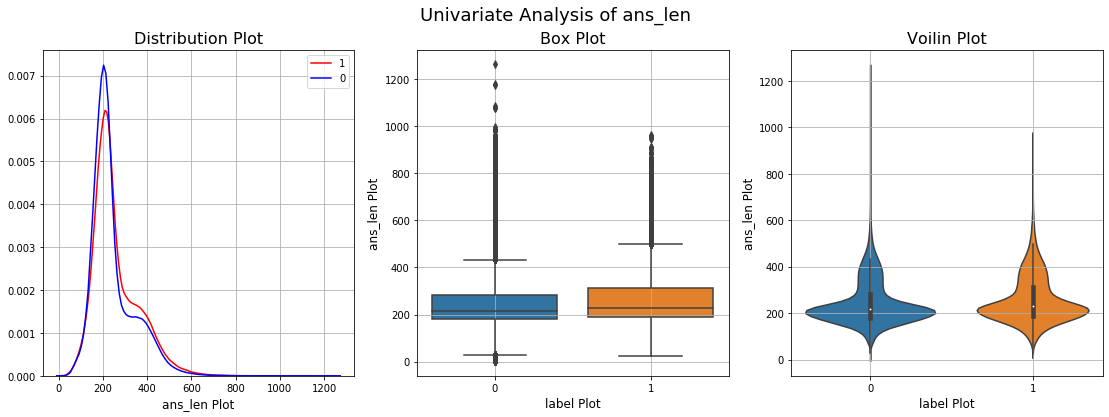

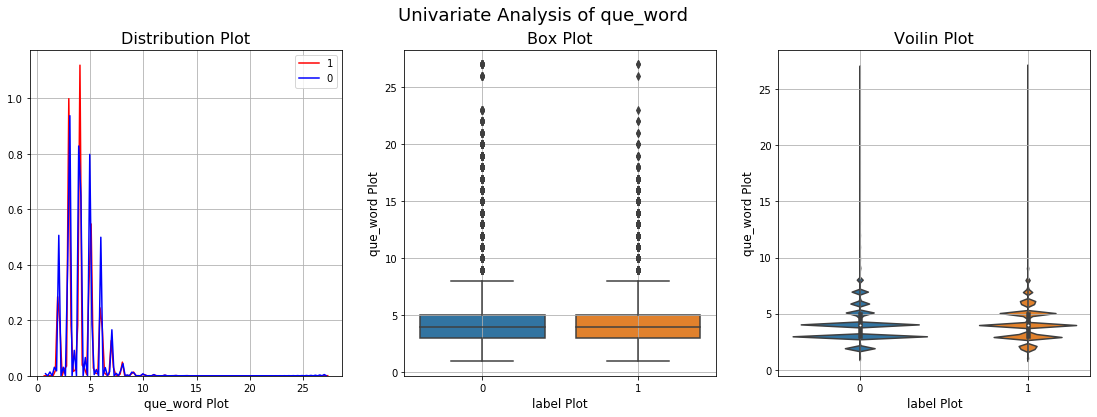

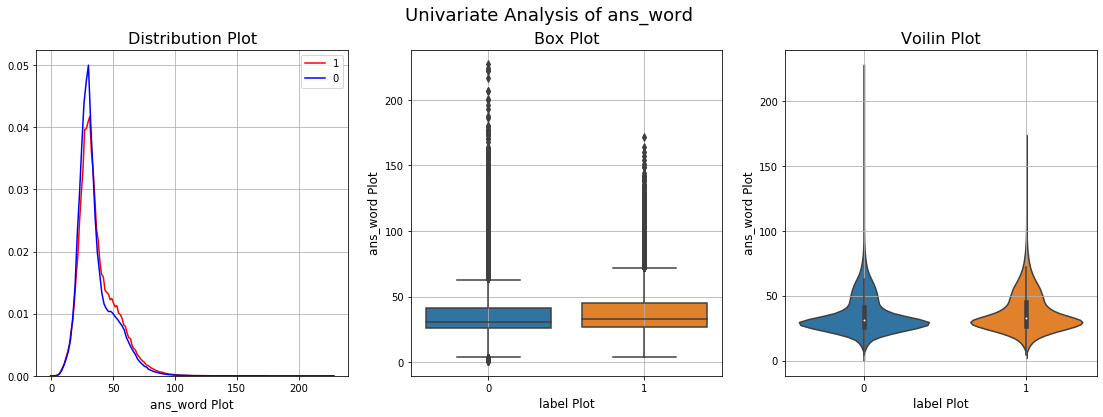

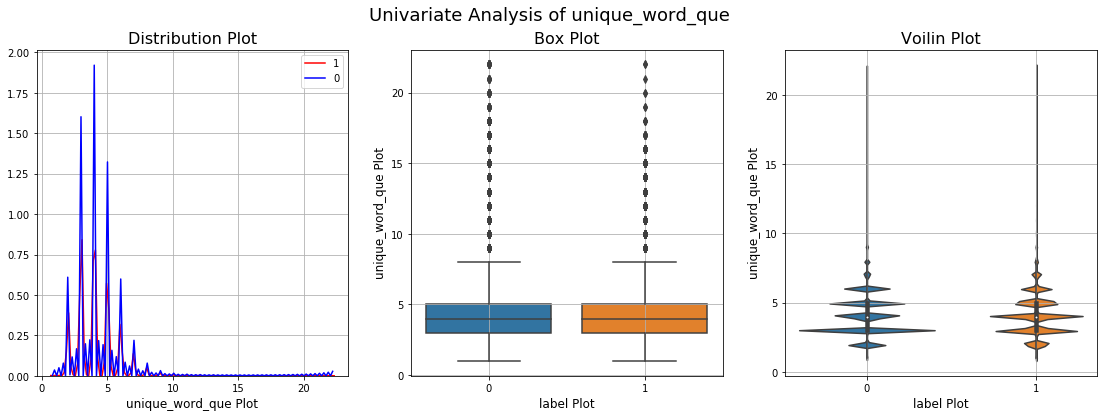

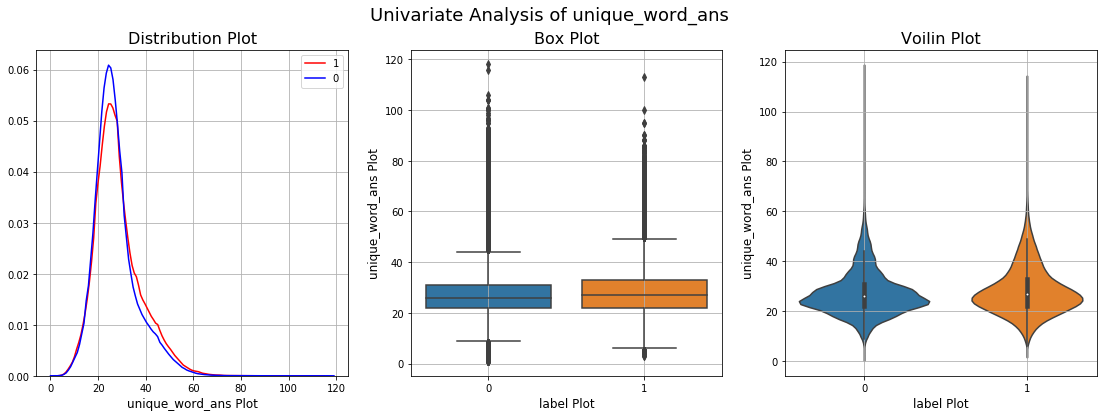

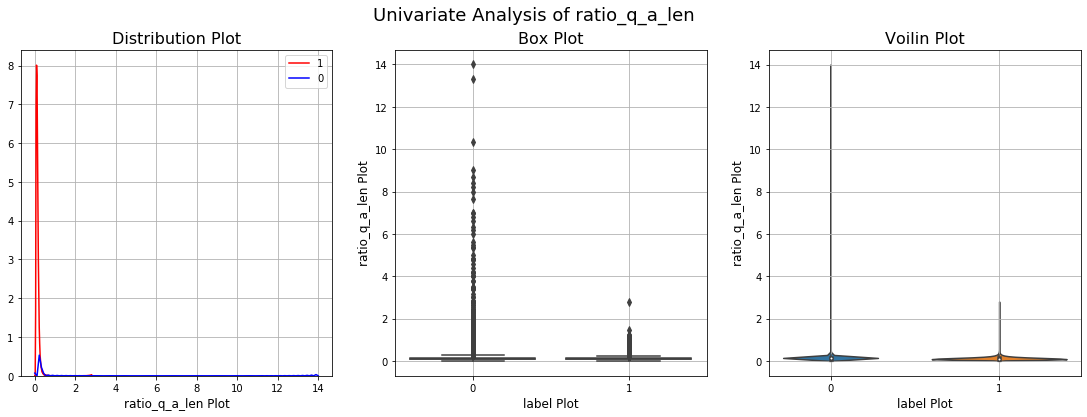

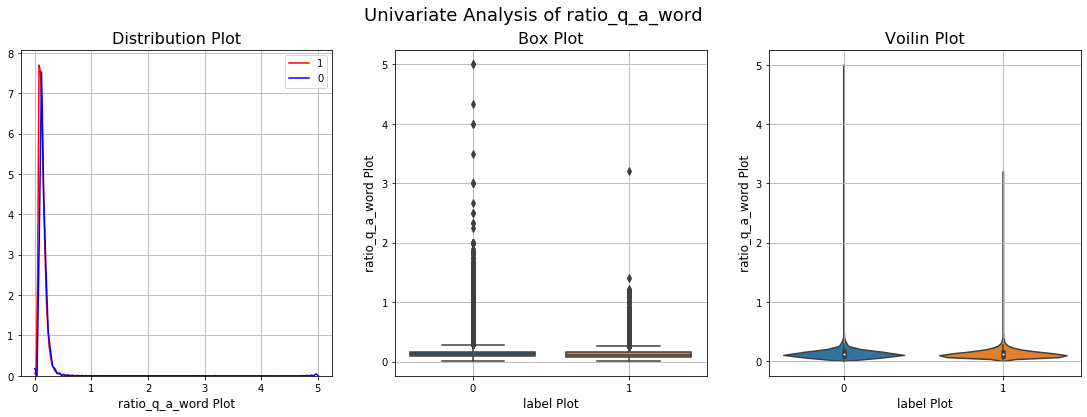

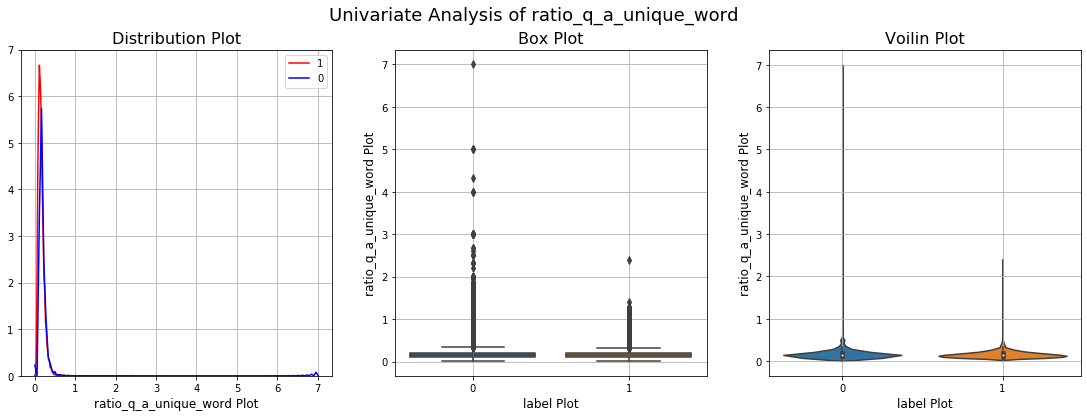

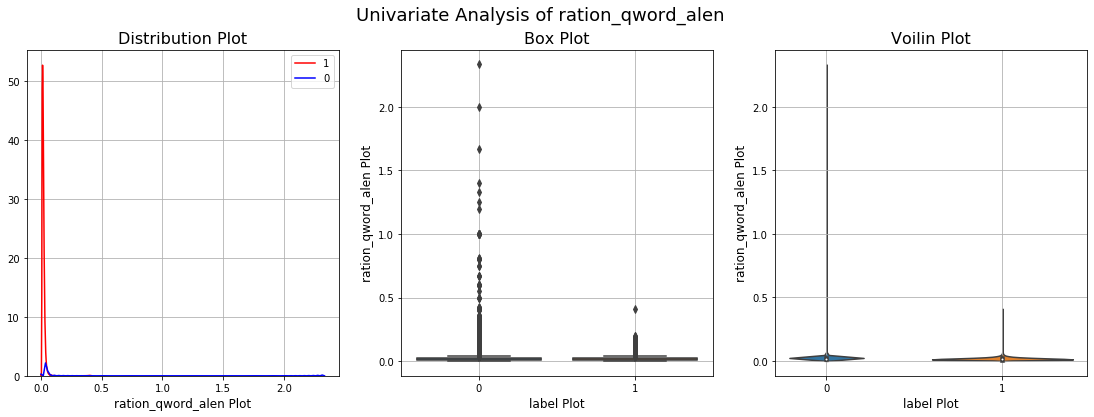

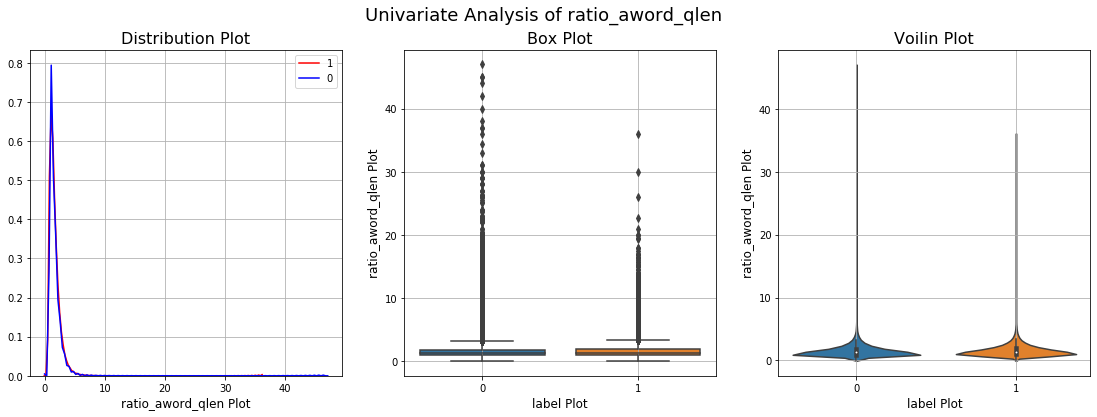

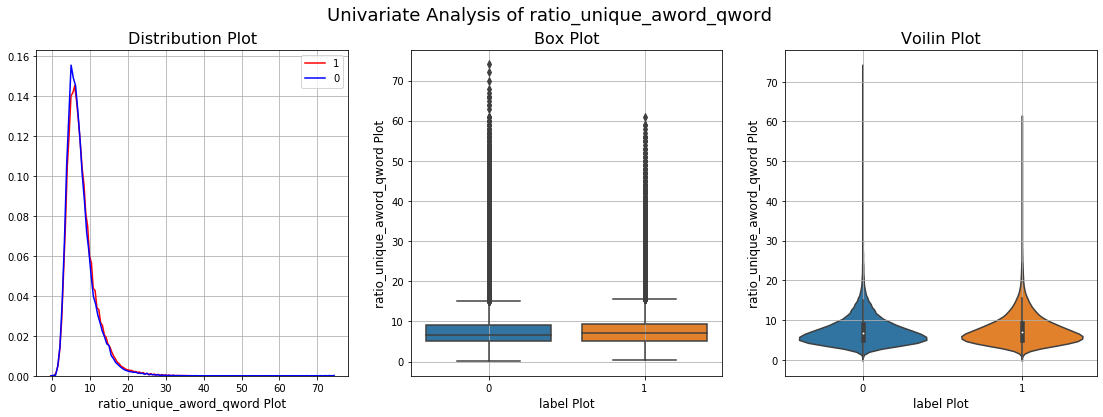

In [0]:
hand_crafted_features = list(df.columns[3:])

for hand_crafted_feature in hand_crafted_features:
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (19, 6))

    # subplot main title and sub title: https://stackoverflow.com/a/35676071/12005970
    fig.suptitle("Univariate Analysis of {}".format(hand_crafted_feature), fontsize=18)

    # https://seaborn.pydata.org/generated/seaborn.distplot.html
    sns.distplot(df[df["label"] == 1][hand_crafted_feature], label = "1", color = 'red', hist = False, ax = ax1)
    sns.distplot(df[df["label"] == 0][hand_crafted_feature], label = "0", color = 'blue', hist = False, ax = ax1)
    ax1.set_title("Distribution Plot", fontsize = 16)
    ax1.set_xlabel("{} Plot".format(hand_crafted_feature), fontsize = 12)
    ax1.grid(1)

    # https://seaborn.pydata.org/generated/seaborn.boxplot.html
    sns.boxplot(x = "label", y = hand_crafted_feature, data = df, ax = ax2)
    ax2.set_title("Box Plot", fontsize = 16)
    ax2.set_xlabel("{} Plot".format("label"), fontsize = 12)
    ax2.set_ylabel("{} Plot".format(hand_crafted_feature), fontsize = 12)
    ax2.grid(1)

    # https://seaborn.pydata.org/generated/seaborn.violinplot.html
    sns.violinplot(x = "label", y = hand_crafted_feature, data = df, ax = ax3)
    ax3.set_title("Voilin Plot", fontsize = 16)
    ax3.set_xlabel("{} Plot".format("label"), fontsize = 12)
    ax3.set_ylabel("{} Plot".format(hand_crafted_feature), fontsize = 12)
    ax3.grid(1)

    plt.plot()

After looking at the above figures, it can be seen that almost all hand-crafted features are not very good to classify the classes because the distribution of both classes is almost overlapping. So they may not play a very important role in classification. But I'm going to keep them to train my models.

### **3.6.2 Multi-Variate Analysis**

**t-SNE Plot**
 * Using only first **5k** datapoints for this.

In [0]:
tsne_X = df[df.columns[3:]].loc[0:5000,:]
tsne_Y = df[["label"]].loc[0:5000]

from sklearn.preprocessing import StandardScaler
data = StandardScaler().fit_transform(tsne_X)
# https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn.manifold import TSNE

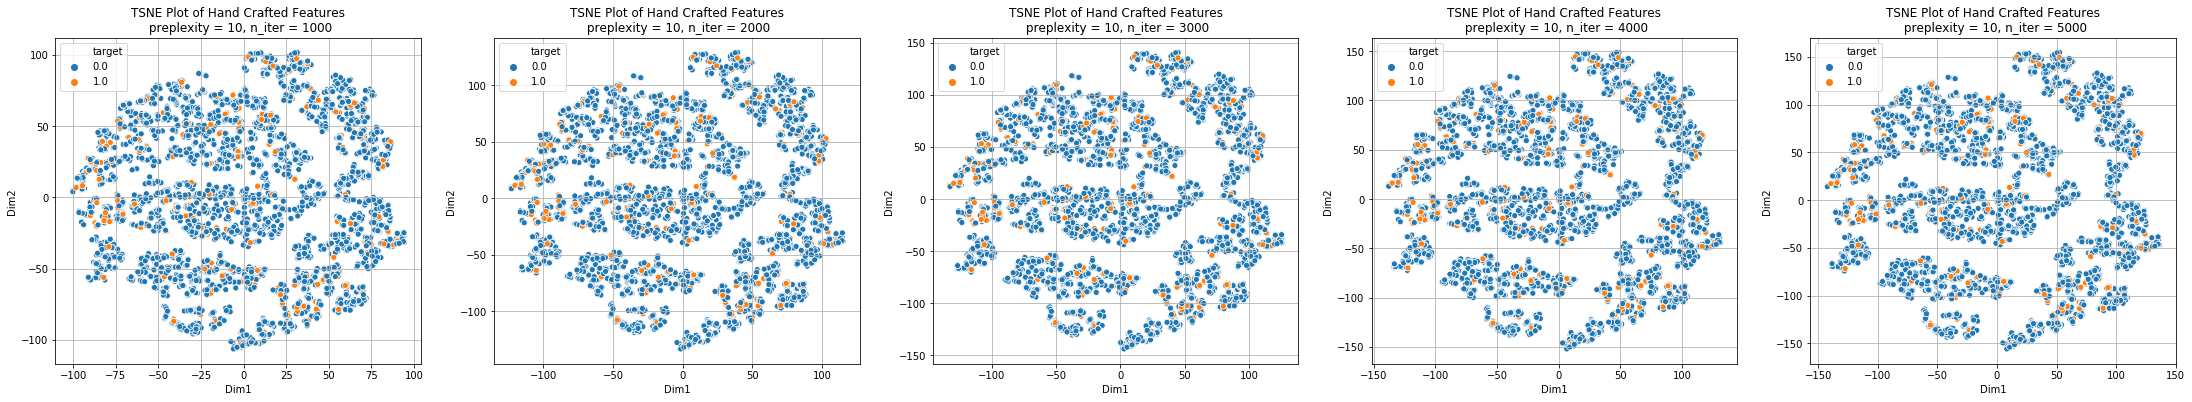

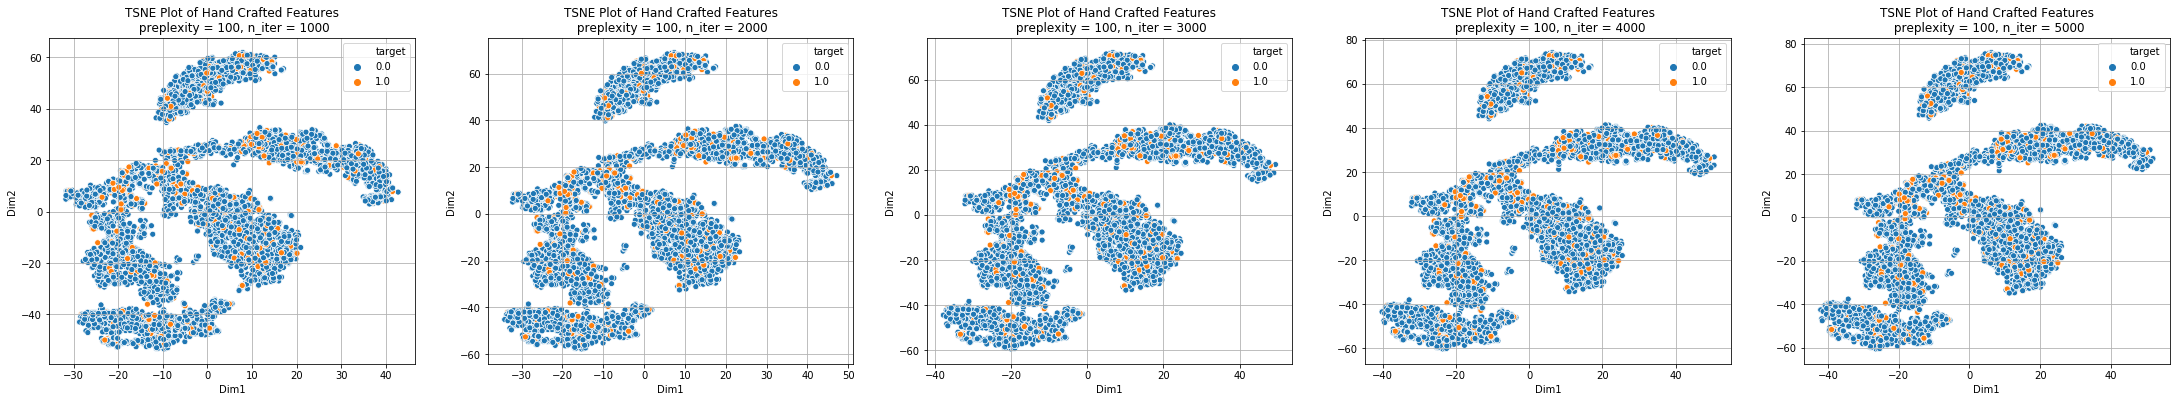

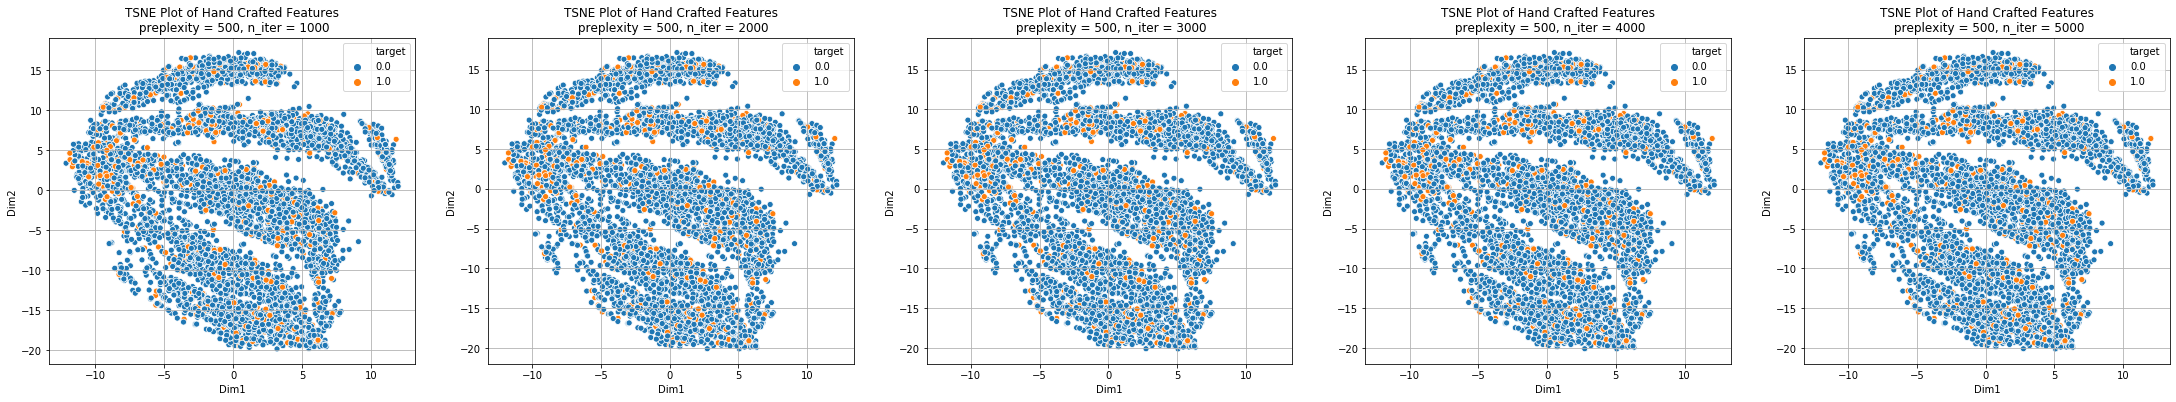

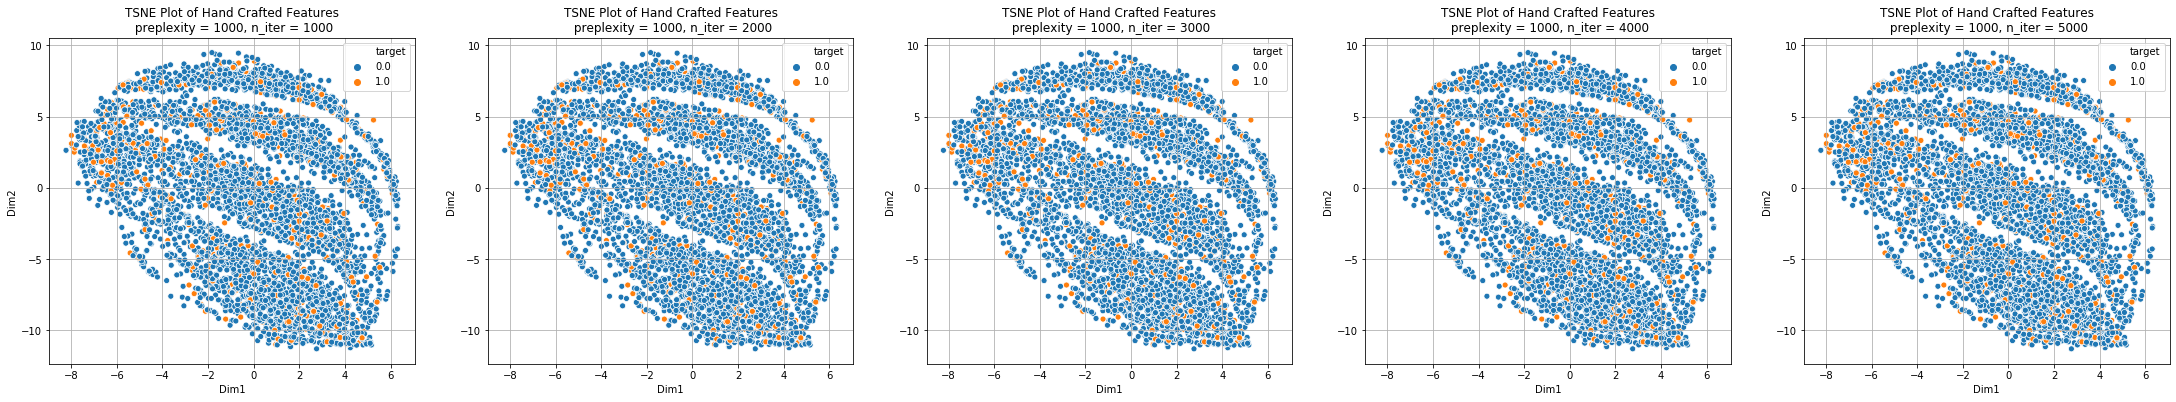

In [0]:
perplexities = [10, 50, 100, 500, 1000]
iterations = [1000, 2000, 3000, 4000, 5000]
for perp in perplexities:
    fig, axs = plt.subplots(1, len(iterations), figsize = (38, 6))
    for i, iteration in enumerate(iterations):
        model = TSNE(n_components = 2, random_state = 0, perplexity = perp, n_iter = iteration)
        tsne_data = model.fit_transform(data)
        tsne_data = np.vstack((tsne_data.T, tsne_Y.values.flatten())).T

        #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html
        tsne_data = pd.DataFrame(data = tsne_data, columns = ('Dim1', 'Dim2', 'target'))
        #seaborn facetgrid plot: https://seaborn.pydata.org/generated/seaborn.FacetGrid.html
        sns.scatterplot(x="Dim1", y="Dim2", hue="target", data = tsne_data, ax = axs[i])
        axs[i].grid('on')
        axs[i].set_title('TSNE Plot of Hand Crafted Features\n preplexity = {}, n_iter = {}'.format(perp, iteration))
    plt.show()

* Various combination of **n_iteration** and **perplexity** has been tried because **t-SNE** is a probabilistic algorithm. So different models have been tried to come to some conclusion.
* As I've taken only **5k** data points to visualize the handcrafted features. But after looking at the above plots it can be seen that these features are not going to play a very important role in classification.

## **3.7 Data Splitting**

* I'll pick first 80% of data for training and next 10% for CV and next 10% for test.

In [0]:
df.to_csv(d+"Processed Data/text_processed.csv", index = False)

In [0]:
df_train = df.iloc[0:int(len(df)*0.8), :] 
df_cv    = df.iloc[int(0.8*len(df)):int(0.9*len(df)), :]
df_test  = df.iloc[int(0.9*len(df)):, :]

X_train, y_train = df_train[[col for col in df.columns if col != "label" and col != "ans_no"]], df_train[["label"]]
X_cv, y_cv       = df_cv[[col for col in df.columns if col != "label" and col != "ans_no"]], df_cv[["label"]]
X_test, y_test   = df_test[[col for col in df.columns if col != "label" and col != "ans_no"]], df_test[["label"]]

print("Number of datapoints in train data: {:,}\n\
Number of datapoints in CV data: {:,}\n\
Number of datapoints in test data: {:,}".format(X_train.shape[0],
                                              X_cv.shape[0],
                                              X_test.shape[0]))

Number of datapoints in train data: 3,850,360
Number of datapoints in CV data: 481,295
Number of datapoints in test data: 481,295


## **3.8 Stability of `question` and `answer` feature in train/CV/test dataset after splitting**

In [0]:
def return_set_words(data_frame, col_name):
    """This will return set of words"""
    corpus = data_frame[col_name].values
    big_text = ""
    for sen in corpus:
        big_text += str(sen)
    return set(big_text.split())

In [0]:
train_question_words_set = return_set_words(X_train, "question")
cv_question_words_set    = return_set_words(X_cv, "question")
test_question_words_set  = return_set_words(X_test, "question")

train_answer_words_set = return_set_words(X_train, "answer")
cv_answer_words_set    = return_set_words(X_cv, "answer")
test_answer_words_set  = return_set_words(X_test, "answer")

**For Questions**

In [0]:
print("There are total unique words in-\n Train: {:,}\
\n CV: {:,}\n Test: {:,}".format(len(train_question_words_set), len(cv_question_words_set),len(test_question_words_set)))
print("\nNumber of common words in `questions` in train and CV are: {:,}\
\n(i.e. Out of {:,} words of CV data {:,} words are in train data which is equal to {:.4f}%)\
\nThere are {:,} words of CV dataset which are not present in train data ({:.4f}%)".format(
    len(train_question_words_set.intersection(cv_question_words_set)),
    len(cv_question_words_set), len(train_question_words_set.intersection(cv_question_words_set)),
    100*len(train_question_words_set.intersection(cv_question_words_set))/len(cv_question_words_set),
    len(cv_question_words_set - train_question_words_set), 
    100*len(cv_question_words_set - train_question_words_set)/len(cv_question_words_set)))

print("\nNumber of common words in `questions` train and TEST are: {:,}\
\n(i.e. Out of {:,} words of TEST data {:,} words are in train data which is equal to {:.4f}%)\
\nThere are {:,} words of TEST dataset which are not present in train data ({:.4f}%)".format(
    len(train_question_words_set.intersection(test_question_words_set)),
    len(test_question_words_set), len(train_question_words_set.intersection(test_question_words_set)),
    100*len(train_question_words_set.intersection(test_question_words_set))/len(test_question_words_set),
    len(test_question_words_set - train_question_words_set), 
    100*len(test_question_words_set - train_question_words_set)/len(test_question_words_set)))

There are total unique words in-
 Train: 390,888
 CV: 73,380
 Test: 75,277

Number of common words in `questions` in train and CV are: 38,566
(i.e. Out of 73,380 words of CV data 38,566 words are in train data which is equal to 52.5566%)
There are 34,814 words of CV dataset which are not present in train data (47.4434%)

Number of common words in `questions` train and TEST are: 38,008
(i.e. Out of 75,277 words of TEST data 38,008 words are in train data which is equal to 50.4909%)
There are 37,269 words of TEST dataset which are not present in train data (49.5091%)


**Visualize it using Venn Diagram**

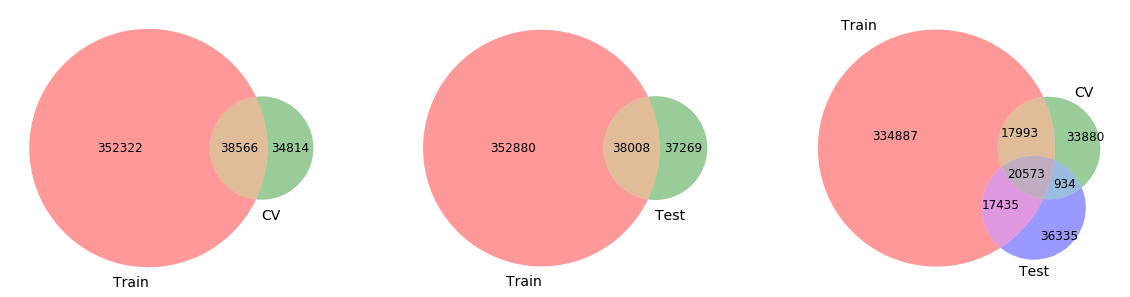

In [0]:
# https://pypi.org/project/matplotlib-venn/
from matplotlib_venn import venn3, venn2
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (20,7))

out1 = venn2([train_question_words_set, cv_question_words_set], set_labels = (['Train', 'CV']), ax = ax1)
out2 = venn2([train_question_words_set, test_question_words_set], set_labels = (['Train', 'Test']), ax = ax2)
out3 = venn3([train_question_words_set, cv_question_words_set, test_question_words_set], set_labels = (['Train', 'CV',
'Test']), ax = ax3)

# toc chnage the font size: https://stackoverflow.com/a/29426251/12005970

for out in [out1, out2, out3]:
    for text in out.set_labels:
         text.set_fontsize(14)
    for text in out.subset_labels:
        text.set_fontsize(12)

plt.show()

**For Answers**

In [0]:
print("There are total unique words in-\n Train: {:,}\
\n CV: {:,}\n Test: {:,}".format(len(train_answer_words_set), len(cv_answer_words_set),len(test_answer_words_set)))
print("\nNumber of common words in `answers` in train and CV are: {:,}\
\n(i.e. Out of {:,} words of CV data {:,} words are in train data which is equal to {:.4f}%)\
\nThere are {:,} words of CV dataset which are not present in train data ({:.4f}%)".format(
    len(train_answer_words_set.intersection(cv_answer_words_set)),
    len(cv_answer_words_set), len(train_answer_words_set.intersection(cv_answer_words_set)),
    100*len(train_answer_words_set.intersection(cv_answer_words_set))/len(cv_answer_words_set),
    len(cv_answer_words_set - train_answer_words_set), 
    100*len(cv_answer_words_set - train_answer_words_set)/len(cv_answer_words_set)))

print("\nNumber of common words in `answers` in train and TEST are: {:,}\
\n(i.e. Out of {:,} words of TEST data {:,} words are in train data which is equal to {:.4f}%)\
\nThere are {:,} words of TEST dataset which are not present in train data ({:.4f}%)".format(
    len(train_answer_words_set.intersection(test_answer_words_set)),
    len(test_answer_words_set), len(train_answer_words_set.intersection(test_answer_words_set)),
    100*len(train_answer_words_set.intersection(test_answer_words_set))/len(test_answer_words_set),
    len(test_answer_words_set - train_answer_words_set), 
    100*len(test_answer_words_set - train_answer_words_set)/len(test_answer_words_set)))

There are total unique words in-
 Train: 3,665,420
 CV: 673,916
 Test: 655,420

Number of common words in `answers` in train and CV are: 305,647
(i.e. Out of 673,916 words of CV data 305,647 words are in train data which is equal to 45.3539%)
There are 368,269 words of CV dataset which are not present in train data (54.6461%)

Number of common words in `answers` in train and TEST are: 303,520
(i.e. Out of 655,420 words of TEST data 303,520 words are in train data which is equal to 46.3092%)
There are 351,900 words of TEST dataset which are not present in train data (53.6908%)


**Visualize it using Venn Diagram**

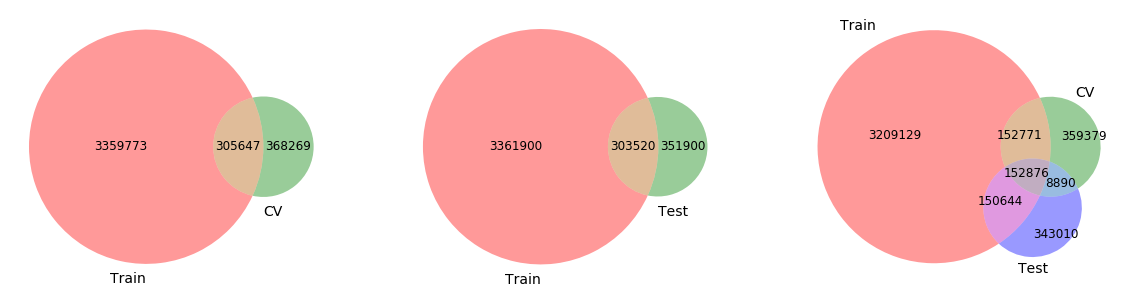

In [0]:
# https://pypi.org/project/matplotlib-venn/
from matplotlib_venn import venn3, venn2
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (20,7))

out1 = venn2([train_answer_words_set, cv_answer_words_set], set_labels = (['Train', 'CV']), ax = ax1)
out2 = venn2([train_answer_words_set, test_answer_words_set], set_labels = (['Train', 'Test']), ax = ax2)
out3 = venn3([train_answer_words_set, cv_answer_words_set, test_answer_words_set], set_labels = (['Train', 'CV',
'Test']), ax = ax3)

# toc chnage the font size: https://stackoverflow.com/a/29426251/12005970

for out in [out1, out2, out3]:
    for text in out.set_labels:
         text.set_fontsize(14)
    for text in out.subset_labels:
        text.set_fontsize(12)

plt.show()

* Questions looks more stable than answers.
* Questions and answers both are not very stable.

# **4. Machine Learning Models**

## **4.1 Some Important Functions**

### **4.1.1 Confusion Matrices**

In [0]:
from sklearn.metrics import confusion_matrix

def plot_C_P_R_matrix(y_true, y_pred, name):
    """
    Funtion to plot confusion, precision and recall matrix
    """
    C = confusion_matrix(y_true, y_pred) #for confusion matrix
    # for presion matrix: take the sum column wise, i.e. column normalization
    P = C/C.sum(axis = 0) # it'll have column sum = 1
    #for recall matrix: take the sum row wise, i.e. row normalization
    R = (C.T/C.sum(axis = 1)).T #it'll have row sum = 1

    fig, (ax1, ax2, ax3)  = plt.subplots(1,3, figsize= (19,4))

    #https://seaborn.pydata.org/generated/seaborn.heatmap.html
    sns.heatmap(C, annot = True, fmt = 'd', annot_kws={"size":15}, ax = ax1)
    ax1.set_title("Confusion Matrix", fontsize = 15)
    ax1.set_xlabel("Predicted", fontsize = 12)
    ax1.set_ylabel("Actual", fontsize = 12)

    sns.heatmap(P, annot = True, fmt = '.3f', annot_kws={"size":15}, ax = ax2)
    ax2.set_title("Precision Matrix", fontsize = 15)
    ax2.set_xlabel("Predicted", fontsize = 12)
    ax2.set_ylabel("Actual", fontsize = 12)

    sns.heatmap(R, annot = True, fmt = '.3f', annot_kws={"size":15}, ax = ax3)
    ax3.set_title("Recall Matrix", fontsize = 15)
    ax3.set_xlabel("Predicted", fontsize = 12)
    ax3.set_ylabel("Actual", fontsize = 12)

    plt.show()

########################################################################################
#######################    function to plot Confusion matrix     #######################
########################################################################################
def plot_confusion_matrix(y_train_pred, y_cv_pred, y_test_pred, thres):
    """
    funtion to plot the precison, recall and confusion matrix for train, cv and test data
    """
    tr_pred = np.where(y_train_pred >= thres, 1, 0)
    cv_pred = np.where(y_cv_pred >= thres, 1, 0)
    te_pred = np.where(y_test_pred >= thres, 1, 0)   

    print(" "*30, "*"*20, "For Train data", "*"*20)
    plot_C_P_R_matrix(y_train.values.flatten(), tr_pred, name = "Train")

    print(" "*30, "*"*20, "For CV data", "*"*20)
    plot_C_P_R_matrix(y_cv.values.flatten(), cv_pred, name = "CV")

    print(" "*30, "*"*20, "For Test data", "*"*20)
    plot_C_P_R_matrix(y_test.values.flatten(), te_pred, name = "Test")

########################################################################################
#######################    function to plot mrr vs hype-parameter matrix     ###########
########################################################################################
def plot_mrr(hyp, tr_mrr, cv_mrr, hyp_name):
    '''
    plots the train and CV mrr vs hyper-paramter
    '''
    plt.figure(figsize=(10,7))
    plt.plot(hyp, tr_mrr, label = 'Train')
    plt.plot(hyp, cv_mrr, label = 'CV')
    plt.xlabel('{}'.format(hyp_name), fontsize = 12)
    plt.ylabel('MRR', fontsize = 12)
    plt.title('MRR vs hyper-parameter {}'.format(hyp_name), fontsize = 15)
    plt.legend(fontsize = 12)
    plt.grid(1)
    plt.show()

### **4.1.2 Tunning Function**

In [0]:
########################################################################################################
############################  function to tune the logistic regression   ###############################
########################################################################################################
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

def tune_log_reg(X_tr,X_cv, Y_tr, Y_cv):
    """
    This function will tune the hyper-parameters of and retunrs the model with best parameter
    This will tune for logisitc regression
    """
    print("*"*100)
    print("*"*100)
    print("Tunning the parameter...\n")
    C = [10**i for i in range(-7,5)]
    tr_mrr = []
    cv_mrr = []
    for i, c in enumerate(C):
        st = time.time()
        log_reg = LogisticRegression(C = c, class_weight = cl_wt, solver='saga', random_state = 42)
        log_reg.fit(X_tr, y_train)
        y_tr_pred = log_reg.predict_proba(X_tr)[:,1]
        y_cv_pred = log_reg.predict_proba(X_cv)[:,1]
        tr_mrr.append(get_mrr(Y_tr.values.flatten(), y_tr_pred))
        cv_mrr.append(get_mrr(Y_cv.values.flatten(), y_cv_pred))
        print("Time taken: {:.4f} seconds. at C = {}: train MRR = {:.4f}\
        and CV MRR: {:.4f}".format(time.time()-st, c, tr_mrr[i], cv_mrr[i]))
    print("*"*100)
    print("*"*100)
    best_params = C[np.argmax(cv_mrr)]
    print('\nBest value of hyper-parameter C = ', best_params)
    print("*"*100)
    best_model = LogisticRegression(C = best_params, class_weight = cl_wt, solver='saga', random_state = 42)
    print('\nBest estimator:\n', best_model)
    print("*"*100)
    print('\nploting the train and CV mrr vs hyper-parameter...\n\n')
    plot_mrr(np.log10(C), tr_mrr, cv_mrr, hyp_name= 'np.log10(C)')
    print('*'*100,'\n\n')
    return best_model

########################################################################################################
############################  function to tune the logistic regression #################################
########################################################################################################
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
def tune_DT(X_tr,X_cv, Y_tr, Y_cv):  
    """
    This function will tune the hyper-parameters of and retunrs the model with best parameter
    This will tune for decison tree.
    """
    print("*"*100)
    print("*"*100)
    print("Tunning the parameter...\n")
    depths = [2, 4, 6, 8, 10, 15, 20, 30, 50]
    tr_mrr = []
    cv_mrr = []
    for i, depth in enumerate(depths):
        st = time.time()
        dt = DecisionTreeClassifier(max_depth = depth, class_weight = cl_wt, random_state = 42)
        dt.fit(X_tr, y_train)
        y_tr_pred = dt.predict_proba(X_tr)[:,1]
        y_cv_pred = dt.predict_proba(X_cv)[:,1]
        tr_mrr.append(get_mrr(Y_tr.values.flatten(), y_tr_pred))
        cv_mrr.append(get_mrr(Y_cv.values.flatten(), y_cv_pred))
        print("Time taken: {:.4f} seconds. at max_depth = {}: train MRR = {:.4f}\
        and CV MRR: {:.4f}".format(time.time()-st, depth, tr_mrr[i], cv_mrr[i]))
    print("*"*100)
    print("*"*100)
    best_params = depths[np.argmax(cv_mrr)]
    print('\nBest value of hyper-parameter depth = ', best_params)
    print("*"*100)
    best_model = DecisionTreeClassifier(max_depth = best_params, class_weight = cl_wt, random_state = 42)
    print('\nBest estimator:\n', best_model)
    print("*"*100)
    print('\nploting the train and CV mrr vs hyper-parameter...\n\n')
    plot_mrr(depths, tr_mrr, cv_mrr, hyp_name= 'max_depth')
    print('*'*100,'\n\n')
    return best_model


########################################################################################################
############################          function to tune the GBDT        #################################
########################################################################################################
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#lightgbm-lgbmclassifier
def tune_GBDT(X_tr,X_cv, Y_tr, Y_cv):
    """
    this tunes the GBDT model and return best estimator
    """ 
    print("*"*120)
    print("*"*120)
    print("Tunning the parameter...\n")
    depths = [2, 5, 10, 15, 20]
    estimators = [500, 1000, 2000, 3000]
    tr_mrr = dict()
    cv_mrr = dict()
    for depth in depths:
        for estimator in estimators:
            st = time.time()
            gbdt_clf = LGBMClassifier(max_depth = depth, n_estimators=estimator,
                                      boosting_type = "gbdt", class_weight = cl_wt,
                                      random_state = 42, n_jobs = -1)
            gbdt_clf.fit(X_tr, y_train)
            y_tr_pred = gbdt_clf.predict_proba(X_tr)[:,1]
            y_cv_pred = gbdt_clf.predict_proba(X_cv)[:,1]
            tr_mrr[(depth, estimator)] = get_mrr(Y_tr.values.flatten(), y_tr_pred)
            cv_mrr[(depth, estimator)] = get_mrr(Y_cv.values.flatten(), y_cv_pred)
            print("Time taken: {:.4f} seconds. at max_depth = {} and n_estimator = {}:\
            train MRR = {:.4f} and CV MRR: {:.4f}".format(time.time()-st,
                                                           depth,estimator,
                                                           tr_mrr[(depth, estimator)],
                                                           cv_mrr[(depth, estimator)]))
    print("*"*120)
    print("*"*120) 
    k,v = list(cv_mrr.keys()), list(cv_mrr.values())
    best_params = k[v.index(max(v))]   
    print('\nBest value of hyper-parameter: ', {'max_depth':best_params[0], 'n_estimator':best_params[1]})
    print("*"*120)
    best_model = LGBMClassifier(max_depth = best_params[0], n_estimators=best_params[1],
                                boosting_type = "gbdt", class_weight = cl_wt,
                                random_state = 42, n_jobs = -1)
    print('\nBest estimator:\n', best_model)    
    print("*"*120)
    return best_model

### **4.1.3 Report and Train Model**

In [0]:
########################################################################################################
############################      function to calculate the MRR        #################################
########################################################################################################

from sklearn.metrics import label_ranking_average_precision_score
def get_mrr(y_true, y_pred):
    """
    to calcuate the mrr.
    it take the y_true and y_pred and make list of lists such that
    for each question ten answer result in list.
    """
    y_true = np.array([y_true[i*10:(i+1)*10] for i in range(len(y_true)//10)])
    y_pred = np.array([y_pred[i*10:(i+1)*10] for i in range(len(y_pred)//10)])
    return label_ranking_average_precision_score(y_true, y_pred)

########################################################################################################
############################      function to train the best model     #################################
########################################################################################################

def train_model(X_tr, X_cv, Y_tr, Y_cv, name, path):
    """
    get the tunned model, and then train it.
    after training the model, it saves the model
    """
    if name == "log_reg":
        best_model = tune_log_reg(X_tr, X_cv, Y_tr, Y_cv)
    elif name == "DT":
        best_model = tune_DT(X_tr, X_cv, Y_tr, Y_cv)
    elif (name == "RF"):
        best_model = tune_RF(X_tr, X_cv, Y_tr, Y_cv)
    elif name == "GBDT":
        best_model = tune_GBDT(X_tr, X_cv, Y_tr, Y_cv)

    print("Trainig the model with best hyper-parameters...")
    best_model.fit(X_tr, Y_tr)
    print("Done!")
    print("Saving the model in disk...")
    file_ = path+name+".pkl"
    with open(file_, "wb") as f:
        pickle.dump(best_model, f)
    return best_model

########################################################################################################
############################     function to report the best model     #################################
########################################################################################################

def report_model(model, train_x, cv_x, test_x,  thres = 0.48):
    """
    function take the trained model and report the performance of model on train/cv/test dataset
    """
    y_train_pred = model.predict_proba(train_x)[:,1] 
    y_cv_pred = model.predict_proba(cv_x)[:,1]
    y_test_pred = model.predict_proba(test_x)[:,1]

    mrr_score_tr = get_mrr(y_train.values.flatten(), y_train_pred)
    mrr_score_cv = get_mrr(y_cv.values.flatten(), y_cv_pred)
    mrr_score_te = get_mrr(y_test.values.flatten(), y_test_pred)

    print("For this model:\n Train mrr-score: {:.4f}\
    \n CV mrr-score: {:.4f}\n Test mrr-score: {:.4f}".format(mrr_score_tr,
                                                             mrr_score_cv,
                                                             mrr_score_te))
    plot_confusion_matrix(y_train_pred, y_cv_pred, y_test_pred, thres = thres)
    return mrr_score_tr, mrr_score_cv, mrr_score_te

########################################################################################################
############################     function to report the best model (DL)     ############################
########################################################################################################
def report_model1(model, train_x, cv_x, test_x, batch_size = 1024,  thres = 0.1):
    """
    function take the trained model and report the performance of model on train/cv/test dataset
    """
    y_train_pred = model.predict(train_x, batch_size = batch_size, verbose=1)
    y_cv_pred = model.predict(cv_x, batch_size = batch_size, verbose=1)
    y_test_pred = model.predict(test_x, batch_size = batch_size, verbose=1)

    mrr_score_tr = get_mrr(y_train.values.flatten(), y_train_pred.flatten())
    mrr_score_cv = get_mrr(y_cv.values.flatten(), y_cv_pred.flatten())
    mrr_score_te = get_mrr(y_test.values.flatten(), y_test_pred.flatten())

    print("For this model:\n Train mrr-score: {:.4f}\
    \n CV mrr-score: {:.4f}\n Test mrr-score: {:.4f}".format(mrr_score_tr,
                                                             mrr_score_cv,
                                                             mrr_score_te))
    plot_confusion_matrix(y_train_pred, y_cv_pred, y_test_pred, thres = thres)
    return mrr_score_tr, mrr_score_cv, mrr_score_te

## **4.2 Base/Random Model**

* This is a random model and it'll be used to compare the performance of all models.

For the random model:
 Train mrr-score: 0.2927
 CV mrr-score: 0.2962
 Test mrr-score: 0.2937
                               ******************** For Train data ********************


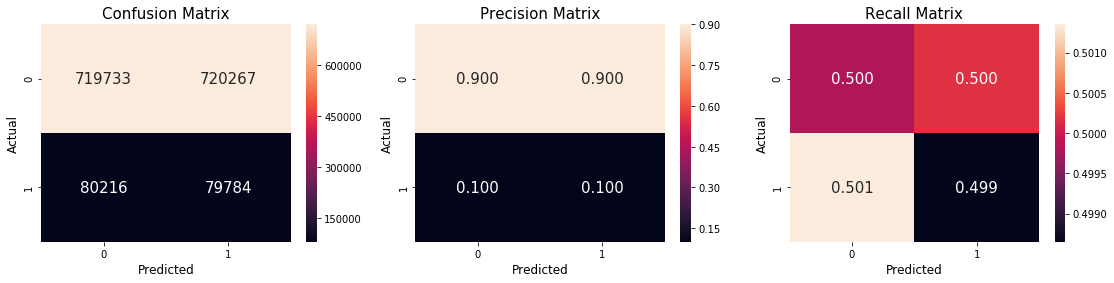

                               ******************** For CV data ********************


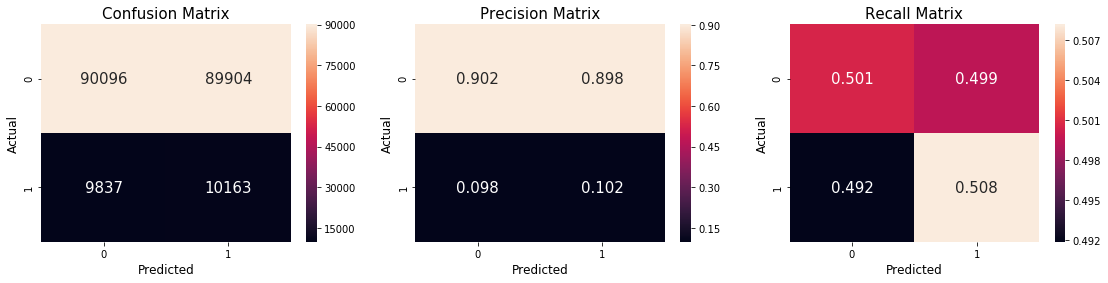

                               ******************** For Test data ********************


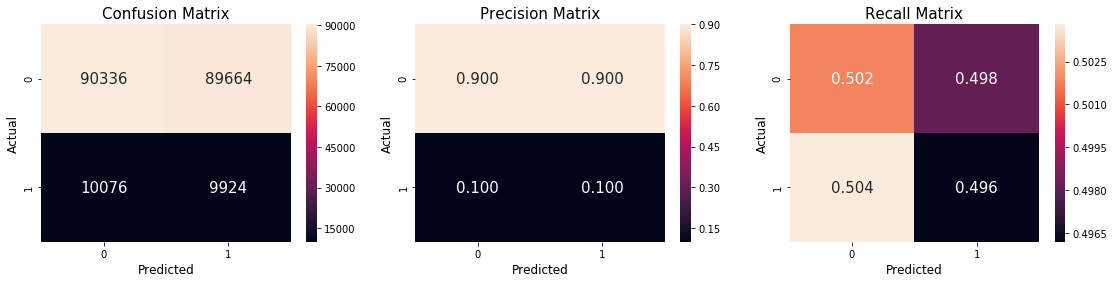

In [0]:
y_train_pred = np.random.rand(len(y_train))
y_cv_pred    = np.random.rand(len(y_cv))
y_test_pred  = np.random.rand(len(y_test))

mrr_tr = get_mrr(y_train.values.flatten(), y_train_pred)
mrr_cv = get_mrr(y_cv.values.flatten(), y_cv_pred)
mrr_te = get_mrr(y_test.values.flatten(), y_test_pred)

print("For the random model:\n\
 Train mrr-score: {:.4f}\n CV mrr-score: {:.4f}\n\
 Test mrr-score: {:.4f}".format(mrr_tr, mrr_cv, mrr_te))
plot_confusion_matrix(y_train_pred, y_cv_pred, y_test_pred)

* so any reasonable model must have **mrr** greater than **0.29**.

## **4.3 Vectorizer Selection/Vectorizer**

### **4.3.1 Vectorizer Selection**

* In this section I'll decide which two vectorization will be used for model training.
* I'm trainng Logistric Regression with **BoW** and **TF-IDF**.
* I'll use uni-gram and bi-gram for **BoW & TF-IDF**.
* Here, I'm deciding which vectorization method can be used for other models, so I'm taking a sample of data to train. I'll take only **250k** (much less than whole train data and greater than CV and test data).

In [0]:
vectorizer_table =  PrettyTable()
vectorizer_table.field_names = ["Vectoirzer", "n-gram", "train metric (mrr)",
                               "CV metric (mrr)", "test metric (mrr)"]

# sample 25k datapoints from train data and 50k datapoints from CV and test data.
# use train_test_split for this
sample_x_train, smaple_y_train, = X_train.iloc[0:250000,:], y_train.head(250000)
print("Number of datapoints in sampled train data: {:,}".format(sample_x_train.shape[0]))

Number of datapoints in sampled train data: 250,000


#### **4.3.1.1 BoW**

> https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

##### **4.3.1.1.1 Uni-gram**

In [0]:
tic = time.time()

# for questions
bow_vectorizer = CountVectorizer(min_df = 1, max_features = 5000)
bow_train_que = bow_vectorizer.fit_transform(sample_x_train["question"].values)
bow_cv_que = bow_vectorizer.transform(X_cv["question"].values) 
bow_test_que = bow_vectorizer.transform(X_test["question"].values)

# for answers
bow_vectorizer = CountVectorizer(min_df = 1, max_features = 5000)
bow_train_ans = bow_vectorizer.fit_transform(sample_x_train["answer"].values)
bow_cv_ans = bow_vectorizer.transform(X_cv["answer"].values) 
bow_test_ans = bow_vectorizer.transform(X_test["answer"].values)

bow_train = hstack((bow_train_que, bow_train_ans))
bow_cv    = hstack((bow_cv_que, bow_cv_ans))
bow_test  = hstack((bow_test_que, bow_test_ans))

print("Shape of featurized\nTrain data: {}\nCV data: {}\nTest data: {}\n".format(bow_train.shape,
                                                                               bow_cv.shape,
                                                                               bow_test.shape))
# training the model
print("Training the model...")
st = time.time()
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
log_reg = LogisticRegression(class_weight = cl_wt)
log_reg.fit(bow_train, smaple_y_train)
print("Done!\nTime taken to train the model: {:.4f} seconds.\n".format(time.time() - st))

# prediction
y_tr_pred = log_reg.predict_proba(bow_train)[:,1]
y_cv_pred = log_reg.predict_proba(bow_cv)[:,1]
y_te_pred = log_reg.predict_proba(bow_test)[:,1]

# Evaluation
print('evaluating...')
train_mrr = get_mrr(smaple_y_train.values.flatten(), y_tr_pred)
cv_mrr    = get_mrr(y_cv.values.flatten(), y_cv_pred)
test_mrr  = get_mrr(y_test.values.flatten(), y_te_pred)

print("Final metric for:\nTrain: {:.5f}\nCV: {:.5f}\nTest: {:.5f}".format(train_mrr, cv_mrr, test_mrr))

vectorizer_table.add_row(["BoW", "uni-gram", train_mrr, cv_mrr, test_mrr])
print("\nTotal time taken to run this cell: {:.4f} seconds".format(time.time() - tic))

Shape of featurized
Train data: (250000, 10000)
CV data: (200000, 10000)
Test data: (200000, 10000)

Training the model...
Done!
Time taken to train the model: 7.0239 seconds.

evaluating...
Final metric for:
Train: 0.46811
CV: 0.36932
Test: 0.36129

Total time taken to run this cell: 37.4404 seconds


##### **4.3.1.1.2 Bi-gram**

In [0]:
tic = time.time()

# for questions
bow_vectorizer = CountVectorizer(ngram_range = (1,2), min_df = 1, max_features = 5000)
bow_train_que = bow_vectorizer.fit_transform(sample_x_train["question"].values)
bow_cv_que = bow_vectorizer.transform(X_cv["question"].values) 
bow_test_que = bow_vectorizer.transform(X_test["question"].values)

# for answers
bow_vectorizer = CountVectorizer(ngram_range = (1,2), min_df = 1, max_features = 5000)
bow_train_ans = bow_vectorizer.fit_transform(sample_x_train["answer"].values)
bow_cv_ans = bow_vectorizer.transform(X_cv["answer"].values) 
bow_test_ans = bow_vectorizer.transform(X_test["answer"].values)

bow_train = hstack((bow_train_que, bow_train_ans))
bow_cv    = hstack((bow_cv_que, bow_cv_ans))
bow_test  = hstack((bow_test_que, bow_test_ans))

print("Shape of featurized\nTrain data: {}\nCV data: {}\nTest data: {}\n".format(bow_train.shape,
                                                                               bow_cv.shape,
                                                                               bow_test.shape))
# training the model
print("Training the model...")
st = time.time()
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
log_reg = LogisticRegression(class_weight = cl_wt)
log_reg.fit(bow_train, smaple_y_train)
print("Done!\nTime taken to train the model: {:.4f} seconds.\n".format(time.time() - st))

# prediction
y_tr_pred = log_reg.predict_proba(bow_train)[:,1]
y_cv_pred = log_reg.predict_proba(bow_cv)[:,1]
y_te_pred = log_reg.predict_proba(bow_test)[:,1]

# Evaluation
print('evaluating...')
train_mrr = get_mrr(smaple_y_train.values.flatten(), y_tr_pred)
cv_mrr    = get_mrr(y_cv.values.flatten(), y_cv_pred)
test_mrr  = get_mrr(y_test.values.flatten(), y_te_pred)

print("Final metric for:\nTrain: {:.5f}\nCV: {:.5f}\nTest: {:.5f}".format(train_mrr, cv_mrr, test_mrr))

vectorizer_table.add_row(["BoW", "bi-gram", train_mrr, cv_mrr, test_mrr])
print("\nTotal time taken to run this cell: {:.4f} seconds".format(time.time() - tic))

Shape of featurized
Train data: (250000, 10000)
CV data: (200000, 10000)
Test data: (200000, 10000)

Training the model...
Done!
Time taken to train the model: 7.1427 seconds.

evaluating...
Final metric for:
Train: 0.46934
CV: 0.37150
Test: 0.36368

Total time taken to run this cell: 79.2194 seconds


#### **4.3.1.2 TF-IDF**

>https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn-feature-extraction-text-tfidfvectorizer

##### **4.3.1.2.1 Uni-gram**

In [0]:
tic = time.time()
# for questions
tfidf_vectorizer = TfidfVectorizer(min_df = 1, max_features = 5000)
tfidf_train_que = tfidf_vectorizer.fit_transform(sample_x_train["question"].values)
tfidf_cv_que = tfidf_vectorizer.transform(X_cv["question"].values) 
tfidf_test_que = tfidf_vectorizer.transform(X_test["question"].values)

# for answers
tfidf_vectorizer = TfidfVectorizer(min_df = 1, max_features = 5000)
tfidf_train_ans = tfidf_vectorizer.fit_transform(sample_x_train["answer"].values)
tfidf_cv_ans = tfidf_vectorizer.transform(X_cv["answer"].values) 
tfidf_test_ans = tfidf_vectorizer.transform(X_test["answer"].values)

tfidf_train = hstack((tfidf_train_que, tfidf_train_ans))
tfidf_cv    = hstack((tfidf_cv_que, tfidf_cv_ans))
tfidf_test  = hstack((tfidf_test_que, tfidf_test_ans))

print("Shape of featurized\nTrain data: {}\nCV data: {}\nTest data: {}\n".format(tfidf_train.shape,
                                                                               tfidf_cv.shape,
                                                                               tfidf_test.shape))
# training the model
print("Training the model...")
st = time.time()
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
log_reg = LogisticRegression(class_weight = cl_wt)
log_reg.fit(tfidf_train, smaple_y_train)
print("Done!\nTime taken to train the model: {:.4f} seconds.\n".format(time.time() - st))

# prediction
y_tr_pred = log_reg.predict_proba(tfidf_train)[:,1]
y_cv_pred = log_reg.predict_proba(tfidf_cv)[:,1]
y_te_pred = log_reg.predict_proba(tfidf_test)[:,1]

# Evaluation
print('evaluating...')
train_mrr = get_mrr(smaple_y_train.values.flatten(), y_tr_pred)
cv_mrr    = get_mrr(y_cv.values.flatten(), y_cv_pred)
test_mrr  = get_mrr(y_test.values.flatten(), y_te_pred)

print("Final metric for:\nTrain: {:.5f}\nCV: {:.5f}\nTest: {:.5f}".format(train_mrr, cv_mrr, test_mrr))

vectorizer_table.add_row(["TF-IDF", "uni-gram", train_mrr, cv_mrr, test_mrr])
print("\nTotal time taken to run this cell: {:.4f} seconds".format(time.time() - tic))

Shape of featurized
Train data: (250000, 10000)
CV data: (200000, 10000)
Test data: (200000, 10000)

Training the model...
Done!
Time taken to train the model: 7.5403 seconds.

evaluating...
Final metric for:
Train: 0.47150
CV: 0.37275
Test: 0.36557

Total time taken to run this cell: 38.4211 seconds


##### **4.3.1.2.2 Bi-gram**

In [0]:
tic = time.time()
# for questions
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1,2), min_df = 1, max_features = 5000)
tfidf_train_que = tfidf_vectorizer.fit_transform(sample_x_train["question"].values)
tfidf_cv_que = tfidf_vectorizer.transform(X_cv["question"].values) 
tfidf_test_que = tfidf_vectorizer.transform(X_test["question"].values)

# for answers
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1,2), min_df = 1, max_features = 5000)
tfidf_train_ans = tfidf_vectorizer.fit_transform(sample_x_train["answer"].values)
tfidf_cv_ans = tfidf_vectorizer.transform(X_cv["answer"].values) 
tfidf_test_ans = tfidf_vectorizer.transform(X_test["answer"].values)

tfidf_train = hstack((tfidf_train_que, tfidf_train_ans))
tfidf_cv    = hstack((tfidf_cv_que, tfidf_cv_ans))
tfidf_test  = hstack((tfidf_test_que, tfidf_test_ans))

print("Shape of featurized\nTrain data: {}\nCV data: {}\nTest data: {}\n".format(tfidf_train.shape,
                                                                               tfidf_cv.shape,
                                                                               tfidf_test.shape))
# training the model
print("Training the model...")
st = time.time()
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
log_reg = LogisticRegression(class_weight = cl_wt)
log_reg.fit(tfidf_train, smaple_y_train)
print("Done!\nTime taken to train the model: {:.4f} seconds.\n".format(time.time() - st))

# prediction
y_tr_pred = log_reg.predict_proba(tfidf_train)[:,1]
y_cv_pred = log_reg.predict_proba(tfidf_cv)[:,1]
y_te_pred = log_reg.predict_proba(tfidf_test)[:,1]

# Evaluation
print('evaluating...')
train_mrr = get_mrr(smaple_y_train.values.flatten(), y_tr_pred)
cv_mrr    = get_mrr(y_cv.values.flatten(), y_cv_pred)
test_mrr  = get_mrr(y_test.values.flatten(), y_te_pred)

print("Final metric for:\nTrain: {:.5f}\nCV: {:.5f}\nTest: {:.5f}".format(train_mrr, cv_mrr, test_mrr))

vectorizer_table.add_row(["TF-IDF", "Bi-gram", train_mrr, cv_mrr, test_mrr])
print("\nTotal time taken to run this cell: {:.4f} seconds".format(time.time() - tic))

Shape of featurized
Train data: (250000, 10000)
CV data: (200000, 10000)
Test data: (200000, 10000)

Training the model...
Done!
Time taken to train the model: 7.6763 seconds.

evaluating...
Final metric for:
Train: 0.47493
CV: 0.37685
Test: 0.36786

Total time taken to run this cell: 79.0477 seconds


**Vectorization Selection**

In [0]:
vectorizer_table.sortby = "test metric (mrr)"
vectorizer_table.reversesort = True
print(vectorizer_table)

+------------+----------+---------------------+---------------------+---------------------+
| Vectoirzer |  n-gram  |  train metric (mrr) |   CV metric (mrr)   |  test metric (mrr)  |
+------------+----------+---------------------+---------------------+---------------------+
|   TF-IDF   | Bi-gram  |  0.4749349523809715 | 0.37685470238094565 | 0.36786412698412224 |
|   TF-IDF   | uni-gram |  0.4714987142857357 |  0.3727502777777712 |  0.365565416666664  |
|    BoW     | bi-gram  | 0.46934031746033616 |  0.3715013888888838 | 0.36367785714285544 |
|    BoW     | uni-gram |  0.4681147936508149 |  0.3693215277777736 |  0.3612851984126966 |
+------------+----------+---------------------+---------------------+---------------------+


* From above model we can see that **TF-IDF** is perfroming better than **BoW**.
* So I'll train my models with **TFIDF** (**bi-gram**).

### **4.3.2 Vectorizer**

#### **4.3.2.1 Data Loading and Splitting**

Dataset is quite big, so I'm going to take the **2m** data points from the dataset (randomly). 

In [0]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os, time, re, random, datetime
# https://stackoverflow.com/a/14463362/12005970
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from numpy import asarray
import pandas as pd
from scipy.sparse import coo_matrix, hstack, load_npz, save_npz
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import pickle

from sklearn.metrics import label_ranking_average_precision_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn import model_selection
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from prettytable import PrettyTable

In [0]:
d = "/content/drive/My Drive/Colab Notebooks/Datasets/Personal Case Study/Search Engine/"

df = pd.read_csv(d+"Processed Data/text_processed.csv", low_memory= True)
df = df.head(2000000) #2 million datapoints
print("Number of sampled datapoints: {:,}".format(df.shape[0]))
print("\n\nNow Let's split the ")

df_train = df.iloc[0:int(len(df)*0.8), :] 
df_cv    = df.iloc[int(0.8*len(df)):int(0.9*len(df)), :]
df_test  = df.iloc[int(0.9*len(df)):, :]

X_train, y_train = df_train[[col for col in df.columns if col != "label"]], df_train[["label"]]
X_cv, y_cv       = df_cv[[col for col in df.columns if col != "label"]], df_cv[["label"]]
X_test, y_test   = df_test[[col for col in df.columns if col != "label"]], df_test[["label"]]

print("Number of datapoints in train data: {:,}\n\
Number of datapoints in CV data: {:,}\n\
Number of datapoints in test data: {:,}".format(X_train.shape[0],
                                              X_cv.shape[0],
                                              X_test.shape[0]))

# creating class weight dictionary
a = y_train["label"].value_counts()
cl_wt = {0: a[1]/10**5, 1: a[0]/10**5}
print(cl_wt)

Number of sampled datapoints: 2,000,000


Now Let's split the 
Number of datapoints in train data: 1,600,000
Number of datapoints in CV data: 200,000
Number of datapoints in test data: 200,000
{0: 1.6, 1: 14.4}


#### **4.3.2.2 BoW (Bi-gram)**

In [0]:
if os.path.isfile(d+"Processed Data/tfidf_train.npz"):
    print("loading the data from disk...")
    tfidf_train = load_npz(d+"Processed Data/tfidf_train.npz")
    tfidf_cv = load_npz(d+"Processed Data/tfidf_cv.npz")
    tfidf_test = load_npz(d+"Processed Data/tfidf_test.npz")
else:
    print("vectorizing the text data (tfidf)...")
    # for questions
    tfidf_vectorizer1 = TfidfVectorizer(ngram_range = (1,2), min_df = 1, max_features = 5000)
    tfidf_train_que = tfidf_vectorizer1.fit_transform(X_train["question"].values)
    tfidf_cv_que = tfidf_vectorizer1.transform(X_cv["question"].values) 
    tfidf_test_que = tfidf_vectorizer1.transform(X_test["question"].values)

    # for answers
    tfidf_vectorizer2 = TfidfVectorizer(ngram_range = (1,2), min_df = 1, max_features = 5000)
    tfidf_train_ans = tfidf_vectorizer2.fit_transform(X_train["answer"].values)
    tfidf_cv_ans = tfidf_vectorizer2.transform(X_cv["answer"].values) 
    tfidf_test_ans = tfidf_vectorizer2.transform(X_test["answer"].values)

    tfidf_train = hstack((tfidf_train_que, tfidf_train_ans)).tocsr()
    tfidf_cv    = hstack((tfidf_cv_que, tfidf_cv_ans)).tocsr()
    tfidf_test  = hstack((tfidf_test_que, tfidf_test_ans)).tocsr()

    print("\nSaving the vectorized data in disk...")
    save_npz(d+"Processed Data/tfidf_train.npz", tfidf_train)
    save_npz(d+"Processed Data/tfidf_cv.npz", tfidf_cv)
    save_npz(d+"Processed Data/tfidf_test.npz", tfidf_test)
    print('saving the vectorizer in disk...')
    with open(d+"Models/vectorizer1.pkl", "wb") as f:
        pickle.dump(tfidf_vectorizer1, f)
    with open(d+"Models/vectorizer2.pkl", "wb") as f:
        pickle.dump(tfidf_vectorizer2, f)

print("Shape of featurized\nTrain data: {}\nCV data: {}\nTest data: {}\n".format(tfidf_train.shape,
                                                                                tfidf_cv.shape,
                                                                                tfidf_test.shape))

loading the data from disk...
Shape of featurized
Train data: (1600000, 10000)
CV data: (200000, 10000)
Test data: (200000, 10000)



#### **4.3.2.3 Hand Crafted Features**

In [0]:
print('getting the hand crafted features...')
train_hand_crafted = X_train[X_train.columns[2:]] 
cv_hand_crafted    = X_cv[X_cv.columns[2:]]
test_hand_crafted  = X_test[X_test.columns[2:]]

print("Shape of hand-crafted features\nTrain data: {}\
    \nCV data: {}\nTest data: {}\n".format(train_hand_crafted.shape,
                                        cv_hand_crafted.shape,
                                        test_hand_crafted.shape))

std = StandardScaler()
train_hand_crafted = std.fit_transform(train_hand_crafted)
cv_hand_crafted = std.transform(cv_hand_crafted)
test_hand_crafted = std.transform(test_hand_crafted)

if not os.path.isfile(d+"Models/std.pkl"):
    print("save the StandardScaler model in disk...")
    with open(d+"Models/std.pkl", "wb") as f:
        pickle.dump(std, f)
else:
    print("file is already saved.")


getting the hand crafted features...
Shape of hand-crafted features
Train data: (1600000, 13)    
CV data: (200000, 13)
Test data: (200000, 13)

file is already saved.


#### **4.3.2.4 Stacking BoW and Hand-Crafted Features**

In [0]:
train_tfidf = hstack((tfidf_train, train_hand_crafted)).tocsr()
cv_tfidf = hstack((tfidf_cv, cv_hand_crafted)).tocsr()
test_tfidf = hstack((tfidf_test, test_hand_crafted)).tocsr()
print("Shape of data:\n Train: {}\n CV: {}\n Test: {}".format(train_tfidf.shape,
                                                              cv_tfidf.shape,
                                                              test_tfidf.shape))

Shape of data:
 Train: (1600000, 10013)
 CV: (200000, 10013)
 Test: (200000, 10013)


## **4.4 Classical ML Models**

In [0]:
model_path = d+"Models/"

model_perf =  PrettyTable()
model_perf.field_names = ["Model Name", "Vectorizer", "Train (mrr)", "CV (mrr)", "Test (mrr)"]

### **4.4.1 Logistic Regession**

****************************************************************************************************
****************************************************************************************************
Tunning the parameter...

Time taken: 43.6519 seconds. at C = 1e-07: train MRR = 0.3467        and CV MRR: 0.3318
Time taken: 45.4114 seconds. at C = 1e-06: train MRR = 0.3476        and CV MRR: 0.3328
Time taken: 47.0829 seconds. at C = 1e-05: train MRR = 0.3535        and CV MRR: 0.3382
Time taken: 49.3242 seconds. at C = 0.0001: train MRR = 0.3869        and CV MRR: 0.3642
Time taken: 168.6093 seconds. at C = 0.001: train MRR = 0.4201        and CV MRR: 0.3969
Time taken: 202.9594 seconds. at C = 0.01: train MRR = 0.4273        and CV MRR: 0.4035
Time taken: 199.9314 seconds. at C = 0.1: train MRR = 0.4281        and CV MRR: 0.4031
Time taken: 200.7395 seconds. at C = 1: train MRR = 0.4282        and CV MRR: 0.4031
Time taken: 199.3089 seconds. at C = 10: train MRR = 0.4283        and

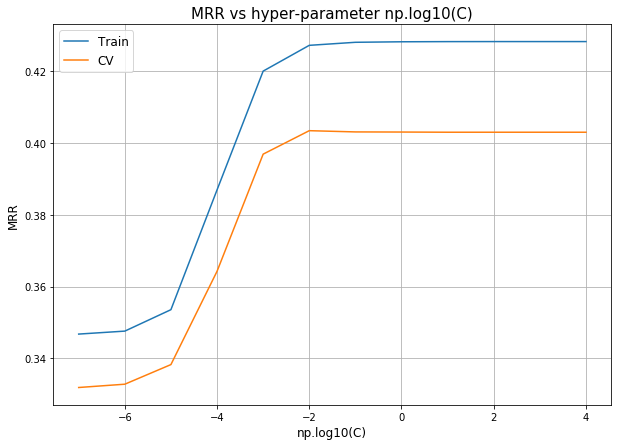

**************************************************************************************************** 


Trainig the model with best hyper-parameters...
Done!
Saving the model in disk...


In [0]:
model = train_model(train_tfidf, cv_tfidf, y_train,y_cv, name = 'log_reg', path = model_path)

* Automatic hyper-parameter selection for above model is good. So no need to re-train the model.

**NOTE:** To visualize the confusion, precision and recall matrices threshold value needs to be set. By doing some cross-validation I found that **threshold = 0.48** gave the best value of **f1-score**. I picked f1-score because it combines both precison and recall.

loading the model...
For this model:
 Train mrr-score: 0.4273    
 CV mrr-score: 0.4035
 Test mrr-score: 0.3876
                               ******************** For Train data ********************


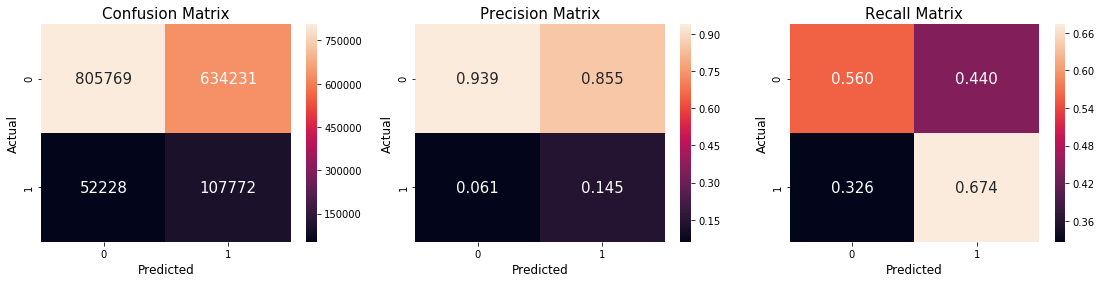

                               ******************** For CV data ********************


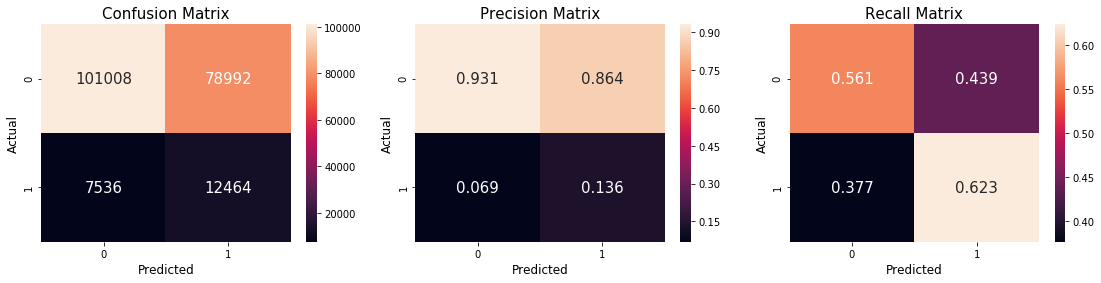

                               ******************** For Test data ********************


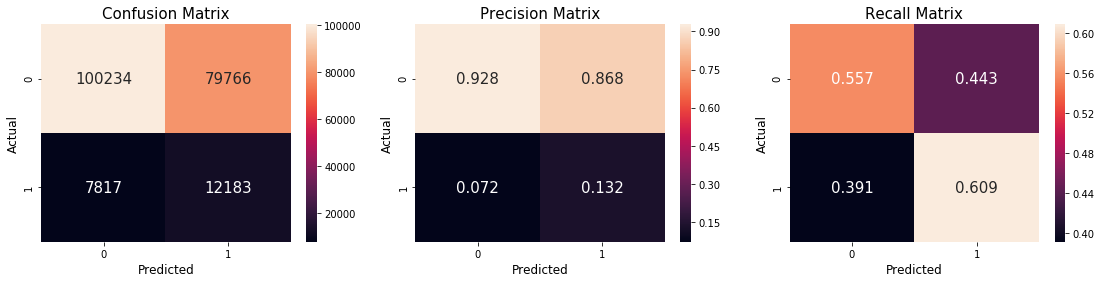

In [0]:
if os.path.isfile(d+"Models/log_reg.pkl"):
    print("loading the model...")
    with open(d+"Models/log_reg.pkl", "rb") as f:
        model = pickle.load(f)
    tr, cv, te = report_model(model, train_tfidf, cv_tfidf, test_tfidf)
    model_perf.add_row(["Logistic Regression", "TF-IDF", tr, cv, te])
else:
    print("run above cell!")

### **4.4.2 Decision Tree**

****************************************************************************************************
****************************************************************************************************
Tunning the parameter...

Time taken: 42.9762 seconds. at max_depth = 2: train MRR = 0.2008        and CV MRR: 0.1888
Time taken: 68.3797 seconds. at max_depth = 4: train MRR = 0.2411        and CV MRR: 0.2211
Time taken: 103.2393 seconds. at max_depth = 6: train MRR = 0.2699        and CV MRR: 0.2563
Time taken: 143.3651 seconds. at max_depth = 8: train MRR = 0.2859        and CV MRR: 0.2639
Time taken: 198.2303 seconds. at max_depth = 10: train MRR = 0.3026        and CV MRR: 0.2767
Time taken: 429.9094 seconds. at max_depth = 15: train MRR = 0.3312        and CV MRR: 0.2870
Time taken: 807.2684 seconds. at max_depth = 20: train MRR = 0.3689        and CV MRR: 0.2966
Time taken: 1612.9089 seconds. at max_depth = 30: train MRR = 0.4412        and CV MRR: 0.3082
Time taken: 3726.9116 sec

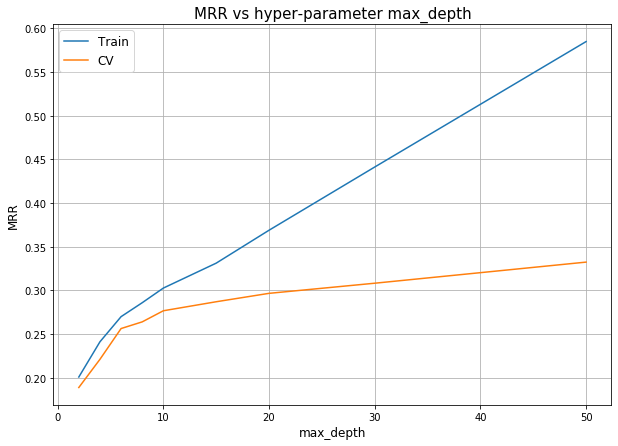

**************************************************************************************************** 


Trainig the model with best hyper-parameters...
Done!
Saving the model in disk...


In [0]:
model = train_model(train_tfidf, cv_tfidf, y_train,y_cv, name = 'DT', path = model_path)

* Automatic hyper-parameter selection for above model is NOT good. So re-training of the model is needed with better hyper-parameter.
* From above plot it is clear that for **max_depth=50** model is overfitting.
* **DT** model will be trained with **max_depth=30**. It is still overfitting, reasonable model must have **CV-mrr score** greater than **0.29**.

In [0]:
clf = DecisionTreeClassifier(class_weight={0: 1.6, 1: 14.4}, max_depth=30,
                             random_state=42)
print(clf)
print('Re-training the model...')
clf.fit(train_tfidf, y_train)
print('saving the model in disk...')
with open(d+"Models/DT.pkl", 'wb') as f:
    pickle.dump(clf, f)
print('Done!')

DecisionTreeClassifier(ccp_alpha=0.0, class_weight={0: 1.6, 1: 14.4},
                       criterion='gini', max_depth=30, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=42, splitter='best')
Re-training the model...
saving the model in disk...
Done!


loading the model...
For this model:
 Train mrr-score: 0.4412    
 CV mrr-score: 0.3082
 Test mrr-score: 0.3042
                               ******************** For Train data ********************


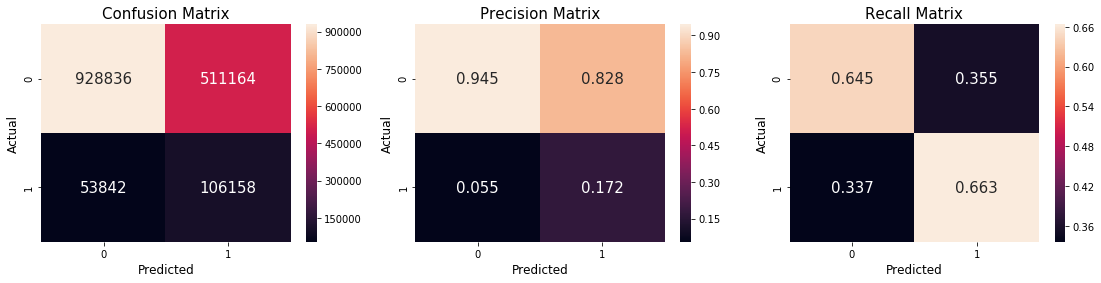

                               ******************** For CV data ********************


                               ******************** For Test data ********************


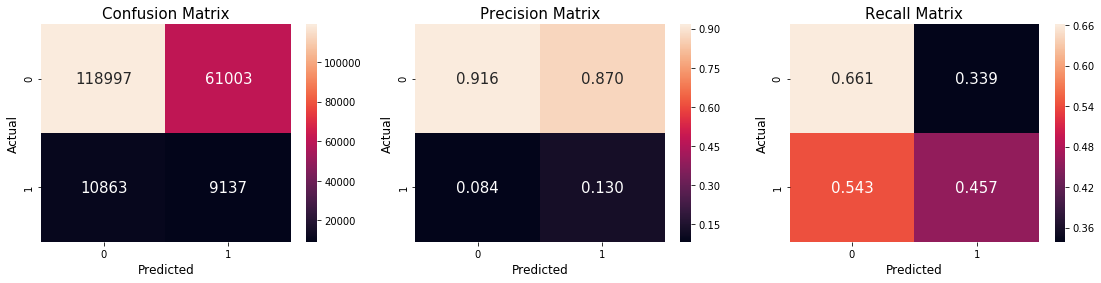

In [0]:
if os.path.isfile(d+"Models/DT.pkl"):
    print("loading the model...")
    with open(d+"Models/DT.pkl", "rb") as f:
        model = pickle.load(f)
    tr, cv, te = report_model(model, train_tfidf, cv_tfidf, test_tfidf)
    model_perf.add_row(["Decision Tree", "tfidf", tr, cv, te])
else:
    print("run above cell!")

### **4.4.3 GBDT**

In [0]:
model = train_model(train_tfidf, cv_tfidf, y_train,y_cv, name = 'GBDT', path = model_path)

************************************************************************************************************************
************************************************************************************************************************
Tunning the parameter...

Time taken: 185.9332 seconds. at max_depth = 2 and n_estimator = 500:            train MRR = 0.4236 and CV MRR: 0.3958
Time taken: 336.1193 seconds. at max_depth = 2 and n_estimator = 1000:            train MRR = 0.4362 and CV MRR: 0.4055
Time taken: 642.0108 seconds. at max_depth = 2 and n_estimator = 2000:            train MRR = 0.4504 and CV MRR: 0.4139
Time taken: 945.1053 seconds. at max_depth = 2 and n_estimator = 3000:            train MRR = 0.4611 and CV MRR: 0.4185
Time taken: 326.6920 seconds. at max_depth = 5 and n_estimator = 500:            train MRR = 0.4771 and CV MRR: 0.4187
Time taken: 606.0288 seconds. at max_depth = 5 and n_estimator = 1000:            train MRR = 0.5085 and CV MRR: 0.4257
Time taken: 11

* Automatic hyper-parameter selection for above model is NOT good. So re-training of the model is needed with better hyper-parameter.
* From above plot it is clear that for **`max_depth=10 & n_estimators=2000`** model is overfitting.
* **GBDT** model will be trained with **`max_depth=5 & n_estimators = 1000`**. With this hyper-parameters model looks good.

In [0]:
clf = LGBMClassifier(boosting_type='gbdt', max_depth=5, n_estimators=1000,
                     class_weight={0: 1.6, 1: 14.4},n_jobs=-1, random_state=42)
print(clf)
print('Re-training the model...')
clf.fit(train_tfidf, y_train)
print('saving the model in disk...')
with open(d+"Models/GBDT.pkl", 'wb') as f:
    pickle.dump(clf, f)
print('Done!')

LGBMClassifier(boosting_type='gbdt', class_weight={0: 1.6, 1: 14.4},
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=5, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=1000, n_jobs=-1, num_leaves=31,
               objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)
Re-training the model...
saving the model in disk...
Done!


loading the model...
For this model:
 Train mrr-score: 0.5085    
 CV mrr-score: 0.4257
 Test mrr-score: 0.4115
                               ******************** For Train data ********************


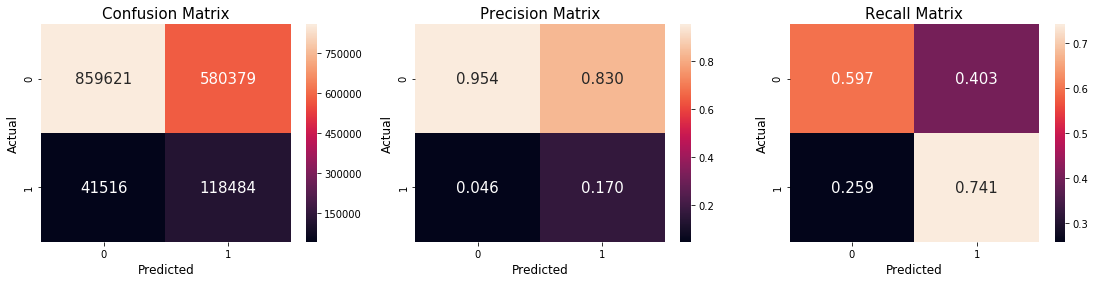

                               ******************** For CV data ********************


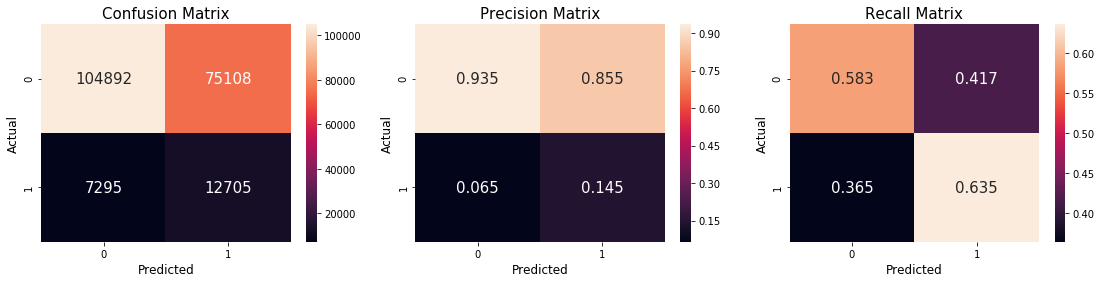

                               ******************** For Test data ********************


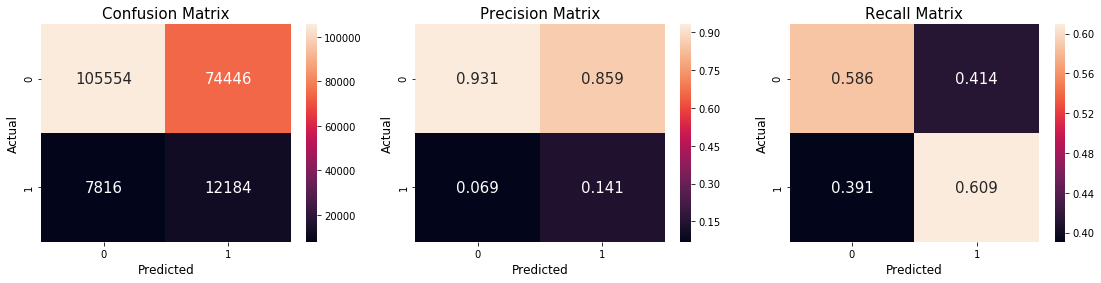

In [0]:
if os.path.isfile(d+"Models/GBDT.pkl"):
    print("loading the model...")
    with open(d+"Models/GBDT.pkl", "rb") as f:
        model = pickle.load(f)
    tr, cv, te = report_model(model, train_tfidf, cv_tfidf, test_tfidf)
    model_perf.add_row(["GBDT", "tfidf", tr, cv, te])
else:
    print("run above cell!")

## **4.5 DL Models**

In [0]:
# import DL libraries
%tensorflow_version 1.x
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv1D, Dense, Activation, LSTM, Reshape, add, dot, multiply
from tensorflow.keras.layers import SpatialDropout1D, concatenate, Bidirectional,CuDNNGRU,CuDNNLSTM
from tensorflow.keras.layers import BatchNormalization, Dropout, concatenate, Embedding, TimeDistributed
from tensorflow.keras.layers import Flatten, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D, AveragePooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, Callback
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model

### **4.5.1 Word Embedding and loading data**

**NOTE:** Using **4m** data points for DL Models.
* 95% for training, 5% for validation and 5% for test.

In [0]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os, time, re, random, datetime
# https://stackoverflow.com/a/14463362/12005970
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from numpy import asarray
import pandas as pd
from scipy.sparse import coo_matrix, hstack, load_npz, save_npz
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import pickle

from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn import model_selection
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from prettytable import PrettyTable

In [0]:
d = "/content/drive/My Drive/Colab Notebooks/Datasets/Personal Case Study/Search Engine/"
model_path = d+"Models/"

df = pd.read_csv(d+"Processed Data/text_processed.csv", low_memory= True)
df = df.head(4000000) #4 million datapoints
print("Number of sampled datapoints: {:,}".format(df.shape[0]))
print("\n\nNow Let's split the ")

df_train = df.iloc[0:3800000, :] 
df_cv    = df.iloc[3800000:3900000, :]
df_test  = df.iloc[3900000:, :]

X_train, y_train = df_train[[col for col in df.columns if col != "label"]], df_train[["label"]]
X_cv, y_cv       = df_cv[[col for col in df.columns if col != "label"]], df_cv[["label"]]
X_test, y_test   = df_test[[col for col in df.columns if col != "label"]], df_test[["label"]]

print("Number of datapoints in train data: {:,}\n\
Number of datapoints in CV data: {:,}\n\
Number of datapoints in test data: {:,}".format(X_train.shape[0],
                                              X_cv.shape[0],
                                              X_test.shape[0]))

Number of sampled datapoints: 4,000,000


Now Let's split the 
Number of datapoints in train data: 3,800,000
Number of datapoints in CV data: 100,000
Number of datapoints in test data: 100,000


In [0]:
# to create custom callback for prediction: https://stackoverflow.com/a/59231724/12005970
# https://github.com/keras-team/keras/blob/aa21a15bd3b1f5a32f49710d771f2c59deb9c7a0/keras/callbacks.py#L231-L256

class mrr_callback_checkpoint(Callback):
    def __init__(self, filepath, training_data = (), validation_data = (),
                 batch_size = 1024, verbose=0, save_best_only=False):
        super(Callback, self).__init__()
        self.verbose = verbose
        self.filepath = filepath
        self.save_best_only = save_best_only
        self.best = -np.Inf
        self.batch_size = batch_size
        self.x_val, self.y_val = validation_data
        self.x_train, self.y_train = training_data


    def on_epoch_end(self, epoch, logs={}):
        y_pred_train = self.model.predict(self.x_train, batch_size = batch_size)
        y_pred_val = self.model.predict(self.x_val, batch_size = batch_size)
        mrr_train = get_mrr(y_train.values.flatten(), y_pred_train.flatten())
        mrr_cv    = get_mrr(y_cv.values.flatten(), y_pred_val.flatten())
        print('\nEpoch {}: Train MRR: {:.5f} and CV MRR: {:.5f}'.format(epoch+1, mrr_train, mrr_cv))

        if self.save_best_only:
            current = mrr_cv
            if current is None:
                warnings.warn("Can save best model only with {} available, skipping.".format('val mrr-score'), RuntimeWarning)
            else:
                if current > self.best:
                    if self.verbose > 0:
                        print("Epoch %05d: %s improved from %0.5f to %0.5f, saving model to %s"
                              % (epoch+1, 'val mrr-score', self.best, current, self.filepath))
                    self.best = current
                    self.model.save_weights(self.filepath, overwrite=True)
                else:
                    if self.verbose > 0:
                        print("Epoch %05d: %s did not improve" % (epoch+1, 'val mrr-score'))
        else:
            if self.verbose > 0:
                print("Epoch %05d: saving model to %s" % (epoch+1, self.filepath))
            self.model.save_weights(self.filepath, overwrite=True)

In [0]:
def text_to_seq(texts, keras_tokenizer, max_len):
    """this function  return sequence of text after padding/truncating"""
    x = pad_sequences(keras_tokenizer.texts_to_sequences(texts),
                      maxlen = max_len, padding = 'post',truncating = 'post')
    return x

In [0]:
a = [len(i.split()) for i in X_train["question"]]
b = [len(i.split()) for i in X_train["answer"]]
print("maximum lenght of question in train data is :", max(a))
print("maximum lenght of answer in train data is :", max(b))

maximum lenght of question in train data is : 27
maximum lenght of answer in train data is : 222


**NOTE:** But I'm taking maximum lenght of question text = 50 and of answer text = 250.

In [0]:
max_lenght_que = 50
max_lenght_ans = 250

In [0]:
# creating only one token for both question and answer
if os.path.isfile(model_path+"tokens.pkl"):
    print("loading tokenizer from drive...")
    with open(model_path+"tokens.pkl", "rb") as f:
        tokens = pickle.load(f)
    print("loading done.")
else:
    print("tokenizer is not in drive, so let's create it...")
    tokens = Tokenizer()
    # using whole data to create the tokens, becasue W2V model can learn the semantic menaing between words
    # even words which are NOT in train data, but IN CV/test data,
    #  it is better to have those words insetead of zeros.
    tokens.fit_on_texts(list(df["question"]+ " "+ df["answer"]))
    print('saving the tokenizer in disk...')
    with open(model_path+"tokens.pkl", "wb") as f:
        pickle.dump(tokens, f)

# padding the encoded data to make each datapoint of same dimension
encoded_que_train = text_to_seq(X_train["question"].values, tokens, max_lenght_que)
encoded_que_cv    = text_to_seq(X_cv["question"].values, tokens, max_lenght_que)
encoded_que_test  = text_to_seq(X_test["question"].values, tokens, max_lenght_que)

print("Shape of train, cv and test {} questions feature are: {}, {}, {}".format('question',
                                                                       encoded_que_train.shape,
                                                                       encoded_que_cv.shape,
                                                                       encoded_que_test.shape))

# padding the encoded data to make each datapoint of same dimension
encoded_ans_train = text_to_seq(X_train["answer"].values, tokens, max_lenght_ans)
encoded_ans_cv    = text_to_seq(X_cv["answer"].values, tokens, max_lenght_ans)
encoded_ans_test  = text_to_seq(X_test["answer"].values, tokens, max_lenght_ans)

print("Shape of train, cv and test {} answer feature are: {}, {}, {}".format('answer',
                                                                       encoded_ans_train.shape,
                                                                       encoded_ans_cv.shape,
                                                                       encoded_ans_test.shape))

loading tokenizer from drive...
loading done.
Shape of train, cv and test question questions feature are: (3800000, 50), (100000, 50), (100000, 50)
Shape of train, cv and test answer answer feature are: (3800000, 250), (100000, 250), (100000, 250)


> https://nlp.stanford.edu/projects/glove/

> This pre-trained model can be downloaded from this [link](http://nlp.stanford.edu/data/glove.6B.zip) and [link](http://nlp.stanford.edu/data/glove.42B.300d.zip).

* There are 25, 50, 100 and 200 dimensional representation of each word and I'll use 200-demensional model only.

In [0]:
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
file_name = "/content/drive/My Drive/Colab Notebooks/Datasets/Personal Case Study/Glove Vector/glove.6B.200d.txt"
# gettting the length of unique words in train data, and adding (+1) becasue of zeros padding and words are encoded from 1 to n
vocab_size = len(tokens.word_index) + 1
# below array will be used in Embedding layer
embedding_matrix1 = np.zeros((vocab_size, 200), dtype = 'float32')
with open(file_name, 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = [float(i) for i in values[1:]]
        word_index = tokens.word_index.get(word) #index of word in our tokenizer
        if word_index:
            embedding_matrix1[word_index] = vector

### **4.5.2 Conv1d**

* First this model was trained using 200-dimensional represention of each word. Then it is trained using 300-dimenisional vector, but this one did not very good job. It's performance was slighlt low than first W2V model.

>Feng, M., Xiang, B., Glass, M. R., Wang, L., & Zhou, B. (2015, December). Applying deep learning to answer selection: A study and an open task. In 2015 IEEE Workshop on Automatic Speech Recognition and Understanding (ASRU) (pp. 813-820). IEEE.
https://arxiv.org/pdf/1508.01585.pdf

In [0]:
def create_model_1():
    #clearing the graph
    K.clear_session()
    def add_conv1d(input_, na):
        x   = Conv1D(128, 2, activation='relu', padding='same', name = "conv_1d_1_"+str(na))(input_)
        max_pool = MaxPooling1D(pool_size = 2, padding = 'same', name = 'max_pool_'+str(na))(x)
        return max_pool

    que_input  = Input(shape = (max_lenght_que, ), name = "que_layer")
    embed_text1 = Embedding(input_dim = vocab_size, output_dim = 200,
                                weights=[embedding_matrix1], input_length = max_lenght_que,
                                trainable = False, name = 'que_embedding')(que_input)
    # answer input
    ans_input  = Input(shape = (max_lenght_ans, ), name = "ans_layer")
    embed_text2 = Embedding(input_dim = vocab_size, output_dim = 200,
                                weights=[embedding_matrix1], input_length = max_lenght_ans,
                                trainable = False, name = 'ans_embedding')(ans_input)

    max_pool1 = add_conv1d(embed_text1, na = 'q')
    max_pool2 = add_conv1d(embed_text2, na = 'a')

    # dot product of maxpooling of question with maxpooling of answer
    dot1 = Dot(axes=-1, name='dot_of_max')([max_pool1, max_pool2])
    flat1 = Flatten(name='flatten_1')(dot1)

    out = Dense(1, activation='sigmoid', name = "output_layer")(flat1)
    model = Model(inputs = [que_input, ans_input], outputs = out, name = "Model_1")
    return model
model = create_model_1()
print(model.summary())

Model: "Model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
que_layer (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
ans_layer (InputLayer)          [(None, 250)]        0                                            
__________________________________________________________________________________________________
que_embedding (Embedding)       (None, 50, 200)      167166000   que_layer[0][0]                  
__________________________________________________________________________________________________
ans_embedding (Embedding)       (None, 250, 200)     167166000   ans_layer[0][0]                  
____________________________________________________________________________________________

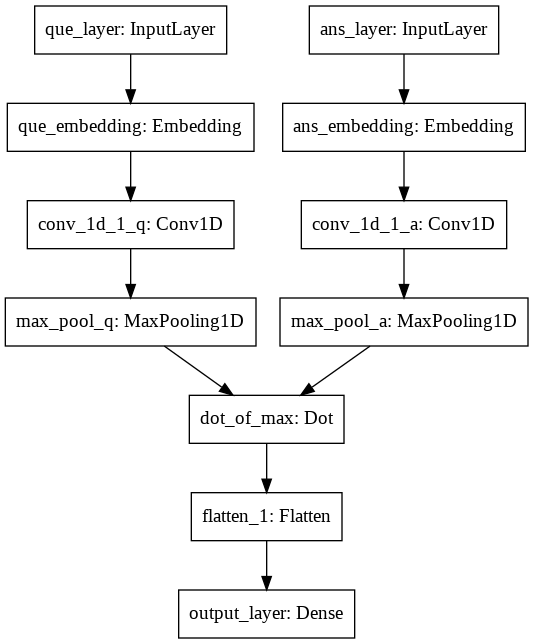

In [0]:
plot_model(model)

In [0]:
n_epochs =  20
batch_size = 1024

log_dir= d+'logs_file/'+"logs1/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#defining callbacks
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1,
                                   batch_size= batch_size, write_grads=True)
es = EarlyStopping(monitor = 'val_loss', mode = 'min', min_delta = 0.001, patience = 5, verbose = 1)
pe = mrr_callback_checkpoint(filepath = model_path+"Model_1.h5",
                            training_data = ([encoded_que_train, encoded_ans_train], y_train),
                            validation_data = ([encoded_que_cv, encoded_ans_cv], y_cv),
                            verbose = 1, save_best_only = True)
#compile the model
model.compile(loss='binary_crossentropy', optimizer = "adam")
# train the model
history = model.fit([encoded_que_train, encoded_ans_train], y_train,
                    validation_data = ([encoded_que_cv, encoded_ans_cv], y_cv),
                    epochs = n_epochs, batch_size = batch_size,
                    callbacks = [es, pe, tensorboard_callback]) # 

Train on 3800000 samples, validate on 100000 samples
Epoch 1/20
3799040/3800000 [============================>.] - ETA: 0s - loss: 0.3147
Epoch 1: Train MRR: 0.43910 and CV MRR: 0.42393
Epoch 00001: val mrr-score improved from -inf to 0.42393, saving model to /content/drive/My Drive/Colab Notebooks/Datasets/Personal Case Study/Search Engine/Models/Model_1.h5
3800000/3800000 [==============================] - 746s 196us/sample - loss: 0.3147 - val_loss: 0.3135
Epoch 2/20
3798016/3800000 [============================>.] - ETA: 0s - loss: 0.3091
Epoch 2: Train MRR: 0.45848 and CV MRR: 0.42989
Epoch 00002: val mrr-score improved from 0.42393 to 0.42989, saving model to /content/drive/My Drive/Colab Notebooks/Datasets/Personal Case Study/Search Engine/Models/Model_1.h5
3800000/3800000 [==============================] - 729s 192us/sample - loss: 0.3090 - val_loss: 0.3131
Epoch 3/20
3798016/3800000 [============================>.] - ETA: 0s - loss: 0.3067
Epoch 3: Train MRR: 0.46662 and CV MR

In [0]:
d = "/content/drive/My Drive/Colab Notebooks/Datasets/Personal Case Study/Search Engine/"
os.chdir(d+'logs_file')
print(os.listdir('./logs1/fit/'))
log_dir = './logs1/fit/20200128-193513'

['20200128-193513']


In [0]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

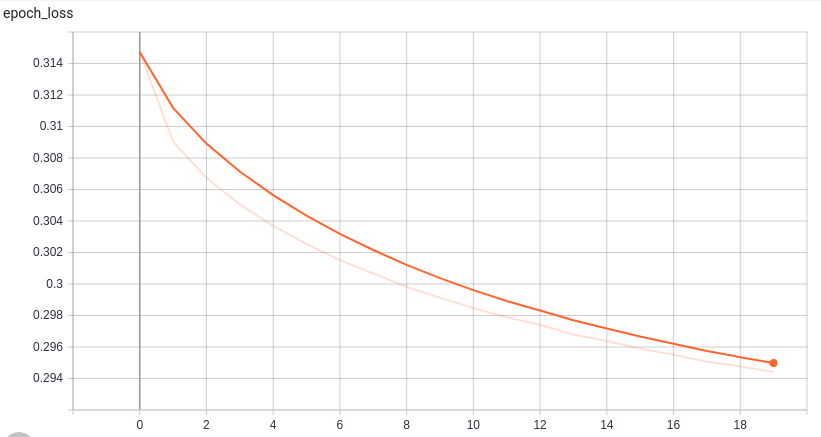

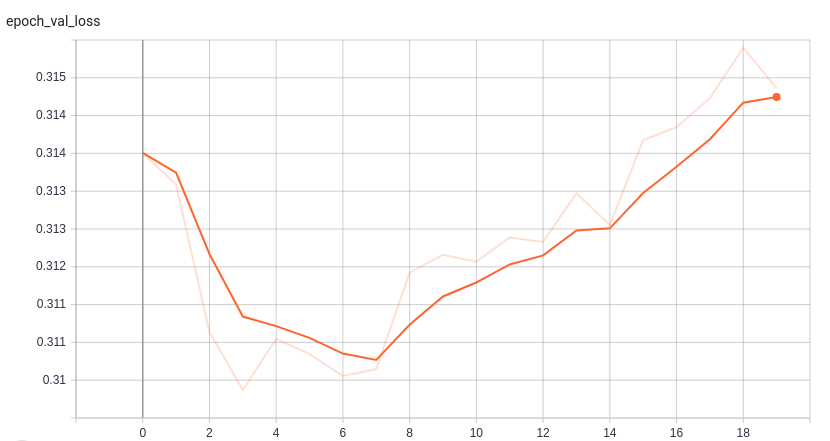

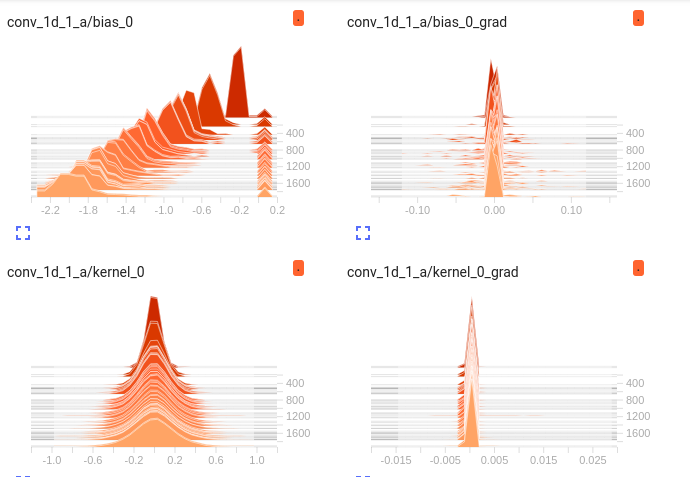

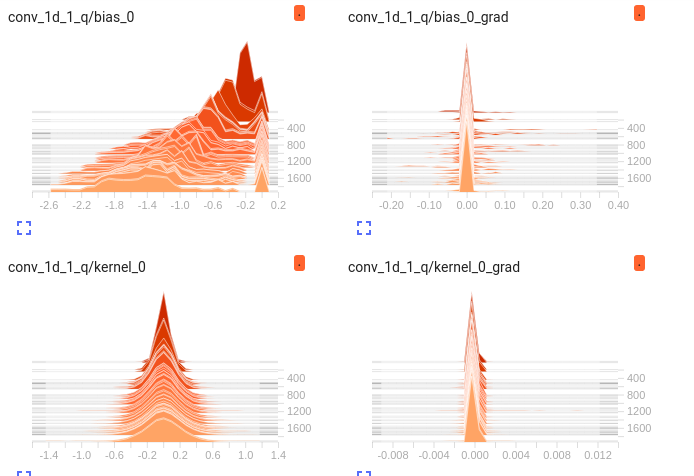

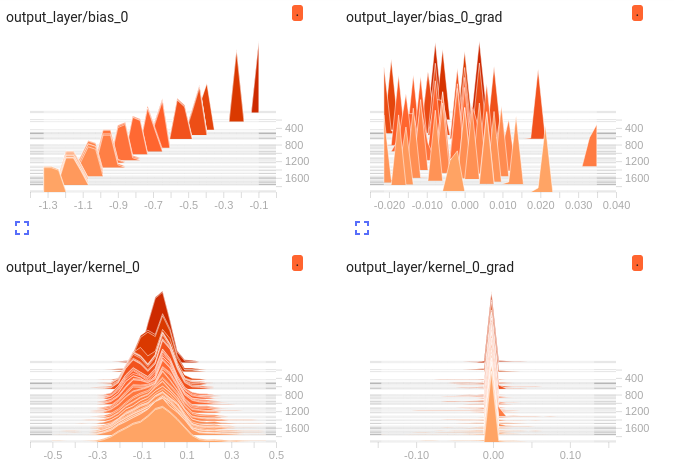

In [1]:
# https://stackoverflow.com/a/35061341/12005970
from IPython.display import Image, display
import os

images = os.listdir('./log_screenshots/Model_1')
images.sort()
for image in images:
    display(Image(filename='./log_screenshots/Model_1/'+image))


**NOTE:** To visualize the confusion, precision and recall matrices threshold value needs to be set. By doing some cross-validation I found that **threshold = 0.1** gave the best value of **f1-score**. I picked f1-score because it combines both precison and recall.

100000/100000 [==============================] - 1s 15us/sample
For this model:
 Train mrr-score: 0.4808    
 CV mrr-score: 0.4390
 Test mrr-score: 0.4411
                               ******************** For Train data ********************


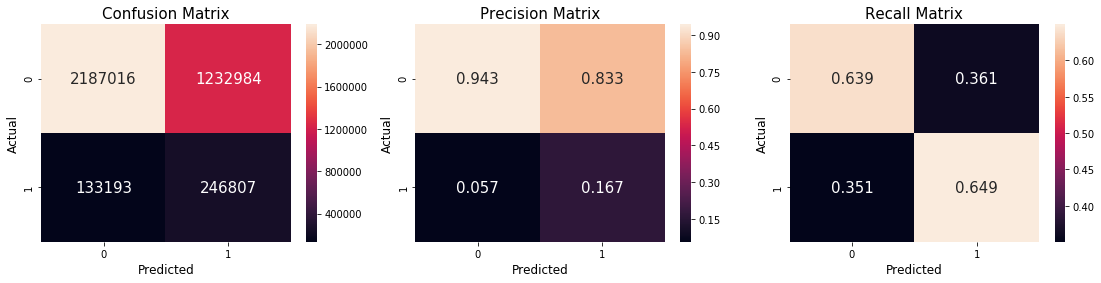

                               ******************** For CV data ********************


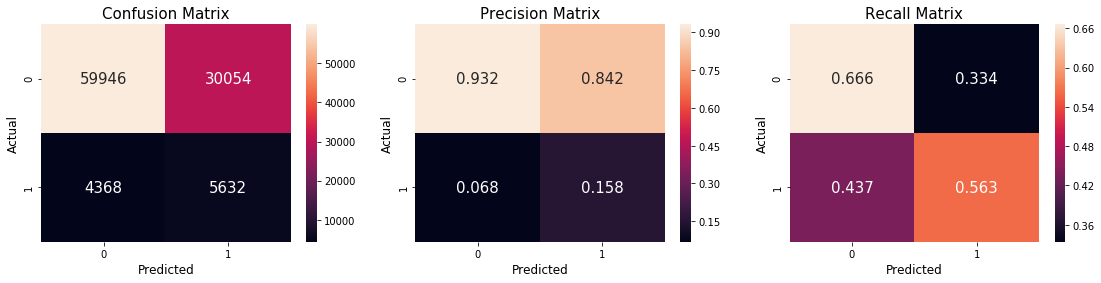

                               ******************** For Test data ********************


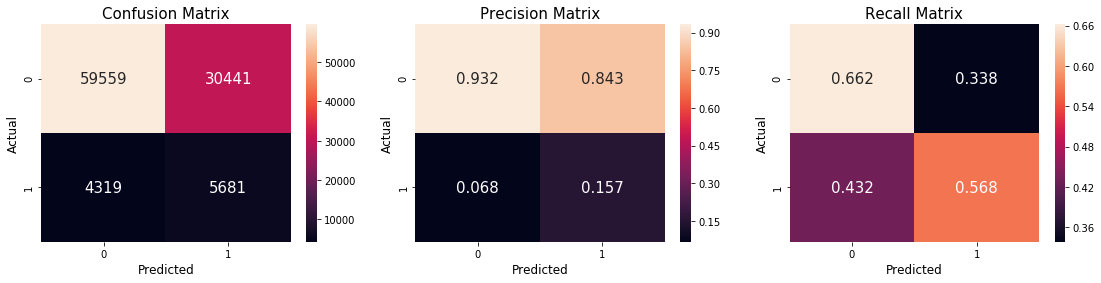

In [0]:
if os.path.isfile(model_path+"Model_1.h5"):
    best_model = create_model_1()
    best_model.load_weights(model_path+"Model_1.h5")
    tr, cv, te = report_model1(best_model,
                               [encoded_que_train, encoded_ans_train],
                               [encoded_que_cv, encoded_ans_cv],
                               [encoded_que_test, encoded_ans_test],
                               batch_size = 1024)
    model_perf.add_row(["DL (Model-1)", "Word Embedding", tr, cv, te])
else:
    print("Tunned model is not is not in disk. Run above cell.")

### **4.5.3 Bidirection GRU model**

In [0]:
def create_model_2():
    #clearing the graph
    K.clear_session()

    def add_bidirection(input_, na):
        x = Bidirectional(CuDNNGRU(32, return_sequences=True), name = "bidirectional_1_"+str(na))(input_)
        avg_pool = AveragePooling1D(pool_size = 2, padding = 'same', name = 'avg_pool_'+str(na))(x)
        return avg_pool
    # question input
    que_input  = Input(shape = (max_lenght_que, ), name = "que_layer")
    embed_text1 = Embedding(input_dim = vocab_size, output_dim = 200,
                                weights=[embedding_matrix1], input_length = max_lenght_que,
                                trainable = False, name = 'que_embedding')(que_input)
    # answer input
    ans_input  = Input(shape = (max_lenght_ans, ), name = "ans_layer")
    embed_text2 = Embedding(input_dim = vocab_size, output_dim = 200,
                                weights=[embedding_matrix1], input_length = max_lenght_ans,
                                trainable = False, name = 'ans_embedding')(ans_input)

    avg_pool1 = add_bidirection(embed_text1, na = 'q')
    avg_pool2 = add_bidirection(embed_text2, na = 'a')

    # dot product of maxpooling of question with maxpooling of answer
    dot1 = dot([avg_pool1, avg_pool2], axes=-1, name='dot_of_max')
    flat1 = Flatten(name='flatten_1')(dot1)
    out = Dense(1, activation='sigmoid', name = "output_layer")(flat1)

    model = Model(inputs=[que_input, ans_input], outputs = out, name = "Model_2")
    return model
model = create_model_2()
print(model.summary())

Model: "Model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
que_layer (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
ans_layer (InputLayer)          [(None, 250)]        0                                            
__________________________________________________________________________________________________
que_embedding (Embedding)       (None, 50, 200)      167166000   que_layer[0][0]                  
__________________________________________________________________________________________________
ans_embedding (Embedding)       (None, 250, 200)     167166000   ans_layer[0][0]                  
____________________________________________________________________________________________

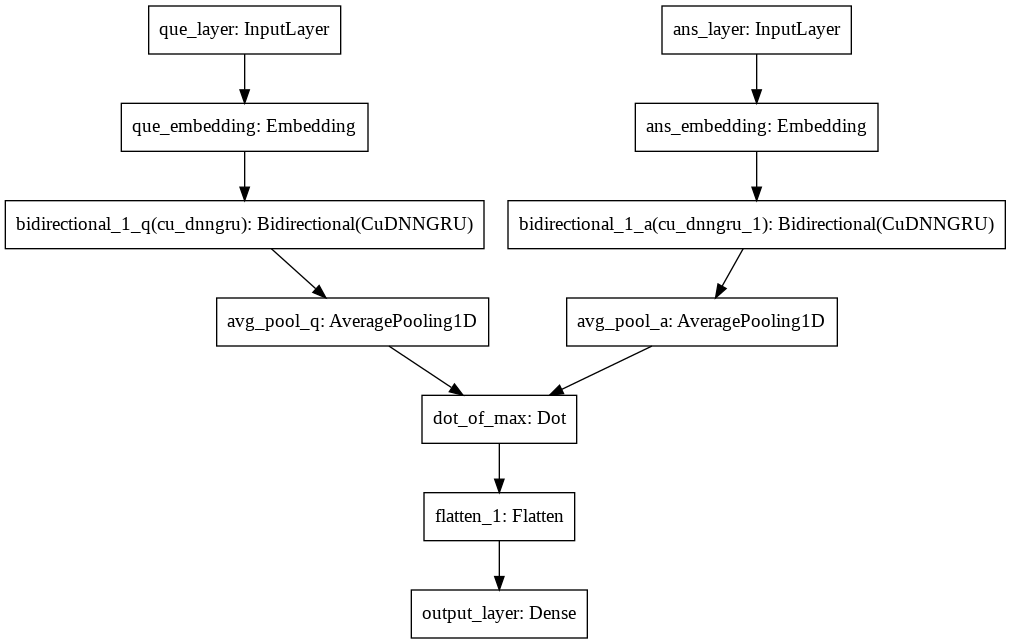

In [0]:
plot_model(model)

In [0]:
n_epochs =  12
batch_size = 1024

# !rm -rf ./logs/ # Clear any logs from previous runs
log_dir= d+'logs_file/'+"logs2/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")#

#defining callbacks
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1,
                                   batch_size= batch_size, write_grads=True)
es = EarlyStopping(monitor = 'val_loss', mode = 'min', min_delta = 0.001, patience = 4, verbose = 1)
pe = mrr_callback_checkpoint(filepath = model_path+"Model_2.h5",
                            training_data = ([encoded_que_train, encoded_ans_train], y_train),
                            validation_data = ([encoded_que_cv, encoded_ans_cv], y_cv),
                            verbose = 1, save_best_only = True)
#compile the model
model.compile(loss='binary_crossentropy', optimizer = "adam")
# train the model
model.fit([encoded_que_train, encoded_ans_train], y_train,
          validation_data = ([encoded_que_cv, encoded_ans_cv], y_cv),
          epochs = n_epochs, batch_size = batch_size,
          callbacks = [es, pe, tensorboard_callback]) # tensorboard_callback

Train on 3800000 samples, validate on 100000 samples
Epoch 1/12
3799040/3800000 [============================>.] - ETA: 0s - loss: 0.3094
Epoch 1: Train MRR: 0.48856 and CV MRR: 0.46650
Epoch 00001: val mrr-score improved from -inf to 0.46650, saving model to /content/drive/My Drive/Colab Notebooks/Datasets/Personal Case Study/Search Engine/Models/Model_2.h5
3800000/3800000 [==============================] - 1035s 272us/sample - loss: 0.3094 - val_loss: 0.3043
Epoch 2/12
3799040/3800000 [============================>.] - ETA: 0s - loss: 0.2982
Epoch 2: Train MRR: 0.50681 and CV MRR: 0.47784
Epoch 00002: val mrr-score improved from 0.46650 to 0.47784, saving model to /content/drive/My Drive/Colab Notebooks/Datasets/Personal Case Study/Search Engine/Models/Model_2.h5
3800000/3800000 [==============================] - 1021s 269us/sample - loss: 0.2982 - val_loss: 0.3028
Epoch 3/12
3799040/3800000 [============================>.] - ETA: 0s - loss: 0.2940
Epoch 3: Train MRR: 0.52181 and CV 

In [0]:
print(os.listdir('./logs2/fit/'))
log_dir = './logs2/fit/20200129-054537'

['20200129-054537']


In [0]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

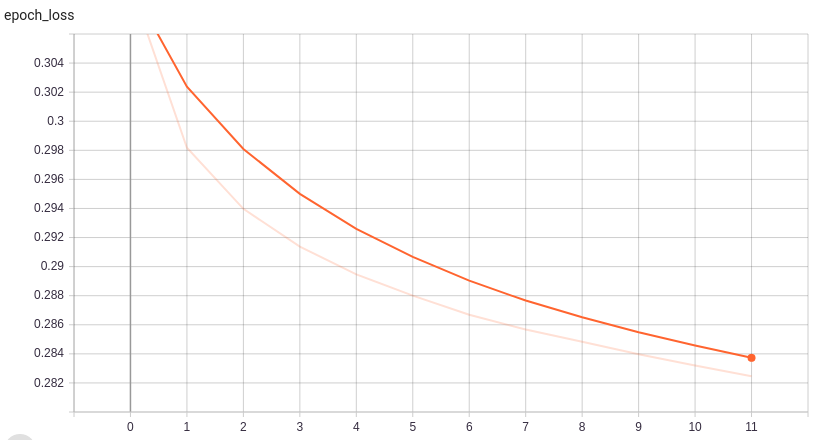

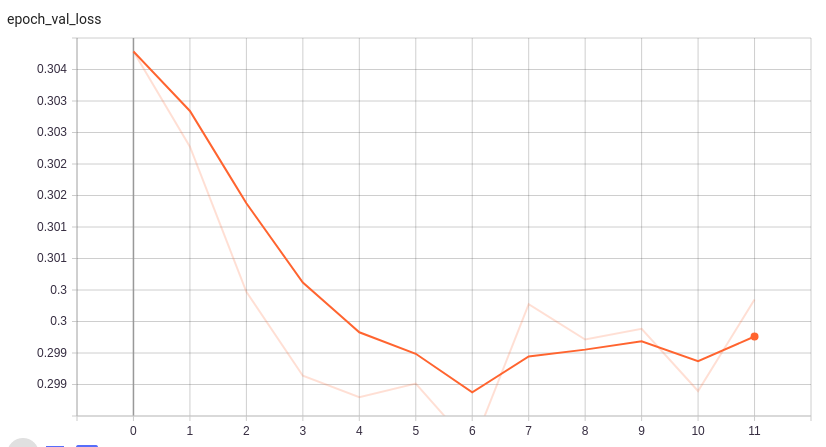

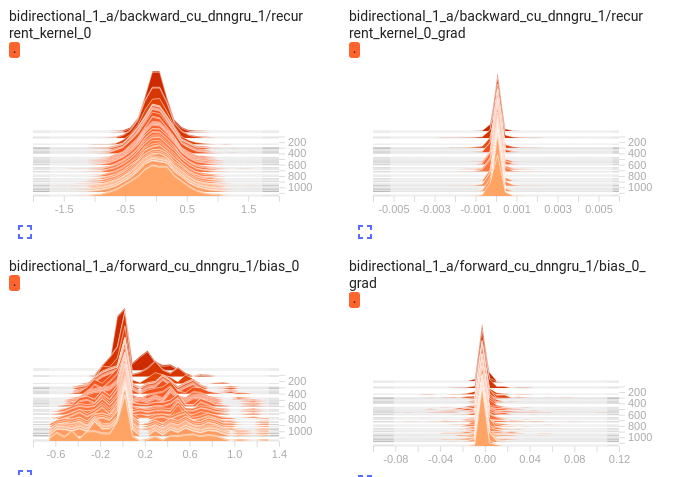

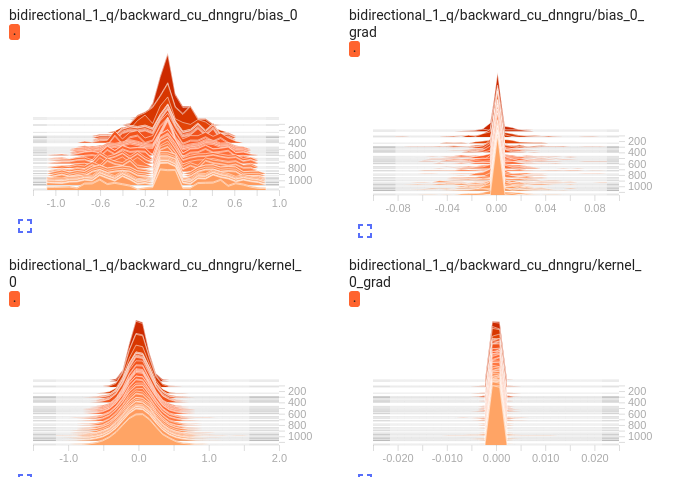

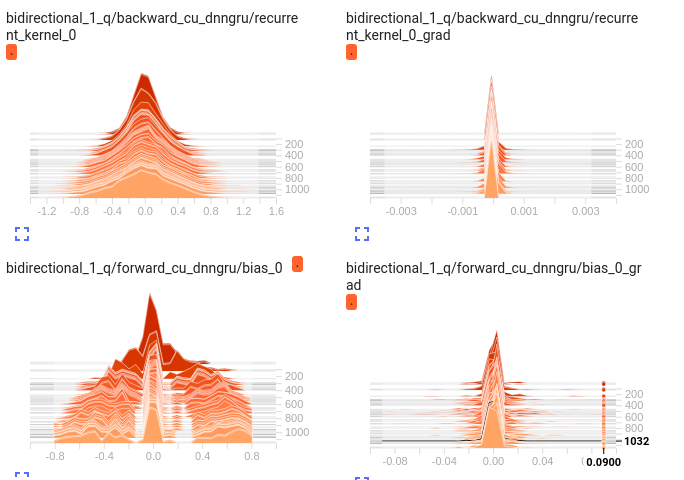

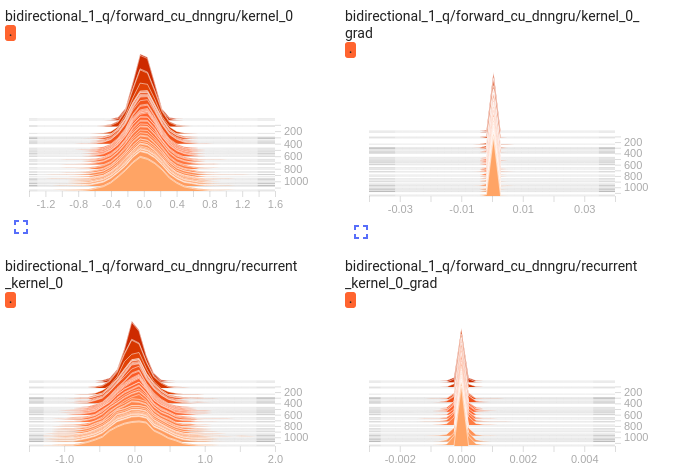

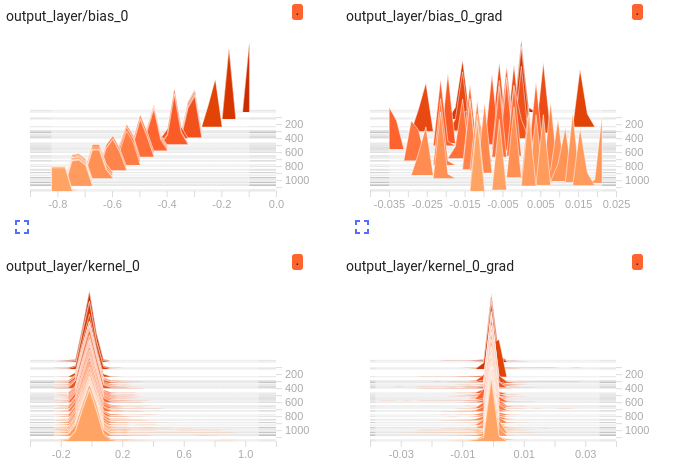

In [2]:
from IPython.display import Image, display
import os

images = os.listdir('./log_screenshots/Model_2')
images.sort()
for image in images:
    display(Image(filename='./log_screenshots/Model_2/'+image))


100000/100000 [==============================] - 4s 37us/sample
For this model:
 Train mrr-score: 0.5462    
 CV mrr-score: 0.4983
 Test mrr-score: 0.4926
                               ******************** For Train data ********************


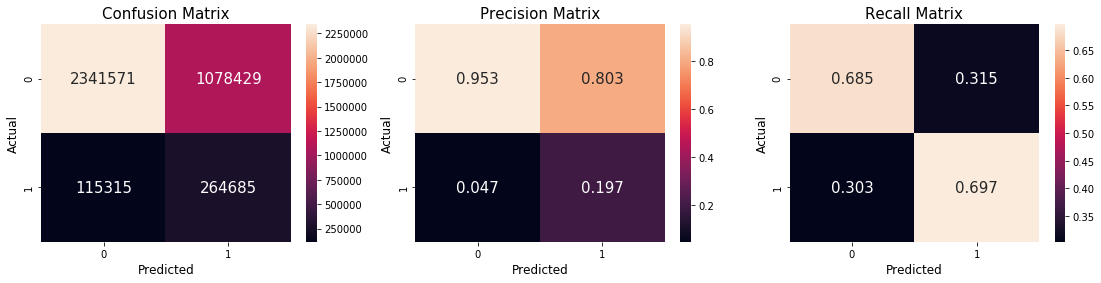

                               ******************** For CV data ********************


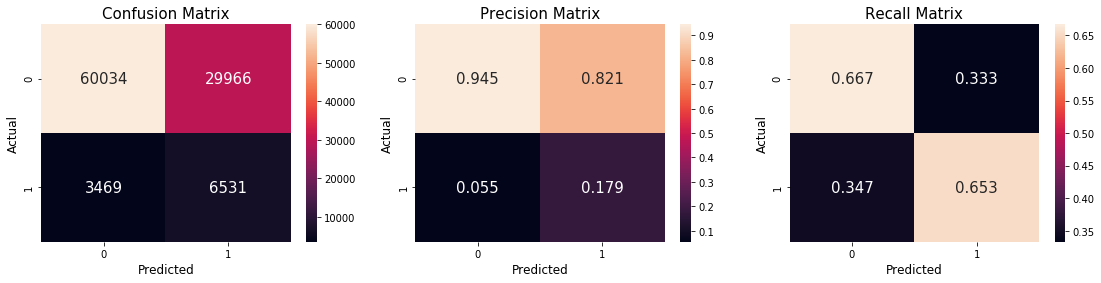

                               ******************** For Test data ********************


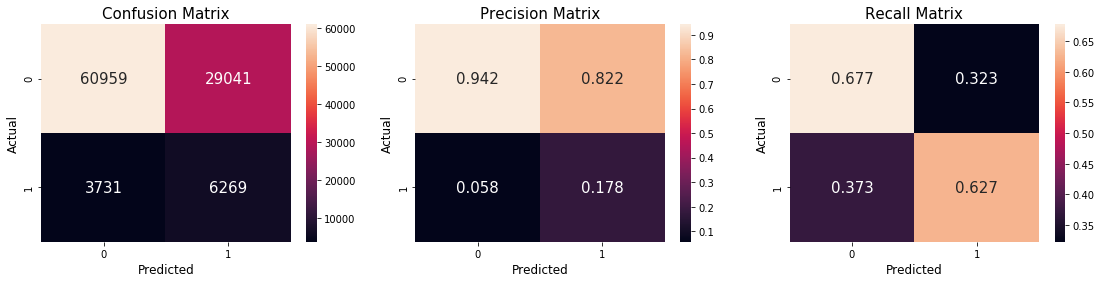

In [0]:
if os.path.isfile(model_path+"Model_2.h5"):
    best_model = create_model_2()
    best_model.load_weights(model_path+"Model_2.h5")
    tr, cv, te = report_model1(best_model,
                               [encoded_que_train, encoded_ans_train],
                               [encoded_que_cv, encoded_ans_cv],
                               [encoded_que_test, encoded_ans_test],
                               batch_size = 1024)
    # model_perf.add_row(["DL (Model- 2)", "Word Embedding", tr, cv, te])
else:
    print("Tunned model is not is not in disk. Run above cell.")

### **4.5.4 LSTM-CNN**

> **QA-LSTM/CNN-attention** https://arxiv.org/pdf/1511.04108.pdf


In [0]:
def create_model_3():
    #clearing the graph
    K.clear_session()
    def add_bidirection(input_, na):
        x = Bidirectional(CuDNNLSTM(32, return_sequences=True), name = "bidirectional_1_"+str(na))(input_)
        x = Conv1D(32*2, 2, activation='tanh', padding='same', name = "conv_1d_1_"+str(na))(x)
        max_pool = MaxPooling1D(pool_size = 2, padding = 'same',name = 'avg_pool_'+str(na))(x)
        return max_pool
    
    # question input
    que_input  = Input(shape = (max_lenght_que, ), name = "que_layer")
    embed_text1 = Embedding(input_dim = vocab_size, output_dim = 200,
                                weights=[embedding_matrix1], input_length = max_lenght_que,
                                trainable = False, name = 'que_embedding')(que_input)
    # answer input
    ans_input  = Input(shape = (max_lenght_ans, ), name = "ans_layer")
    embed_text2 = Embedding(input_dim = vocab_size, output_dim = 200,
                                weights=[embedding_matrix1], input_length = max_lenght_ans,
                                trainable = False, name = 'ans_embedding')(ans_input)
    ans = Bidirectional(CuDNNLSTM(32, return_sequences=True), name = "bidirectional_1_"+str('a'))(embed_text2) 

    # adding the bi-LSTM and CNN on question
    max_pool_q = add_bidirection(embed_text1, na = 'q')

    # adding attention layer b/w question-lstm-cnn output and answer lstm output
    # output of this must have shape as que has.
    # Bahdanau-style attention:: https://www.tensorflow.org/api_docs/python/tf/keras/layers/AdditiveAttention
    attention = tf.keras.layers.AdditiveAttention(use_scale = True, name = 'attention')([max_pool_q, ans])

    # add the CNN layer after attention
    ans = Conv1D(32*2, 2, activation='tanh', padding='same', name = "conv_1d_1_"+str('a'))(attention)
    max_pool_a = MaxPooling1D(pool_size = 2, padding = 'same',name = 'max_pool_'+str('a'))(ans)

    dot_product1 = dot([max_pool_q, max_pool_a], axes = -1, name = 'dot_product_1')

    # flattening the abouve dot product
    flat1 = Flatten(name='flatten_1')(dot_product1)
    out = Dense(1, activation = 'sigmoid', name = "output_layer")(flat1)

    model = Model(inputs=[que_input, ans_input], outputs = out, name = "Model_3")
    return model
model = create_model_3()
print(model.summary())

Model: "Model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
que_layer (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
que_embedding (Embedding)       (None, 50, 200)      167166000   que_layer[0][0]                  
__________________________________________________________________________________________________
bidirectional_1_q (Bidirectiona (None, 50, 64)       59904       que_embedding[0][0]              
__________________________________________________________________________________________________
ans_layer (InputLayer)          [(None, 250)]        0                                            
____________________________________________________________________________________________

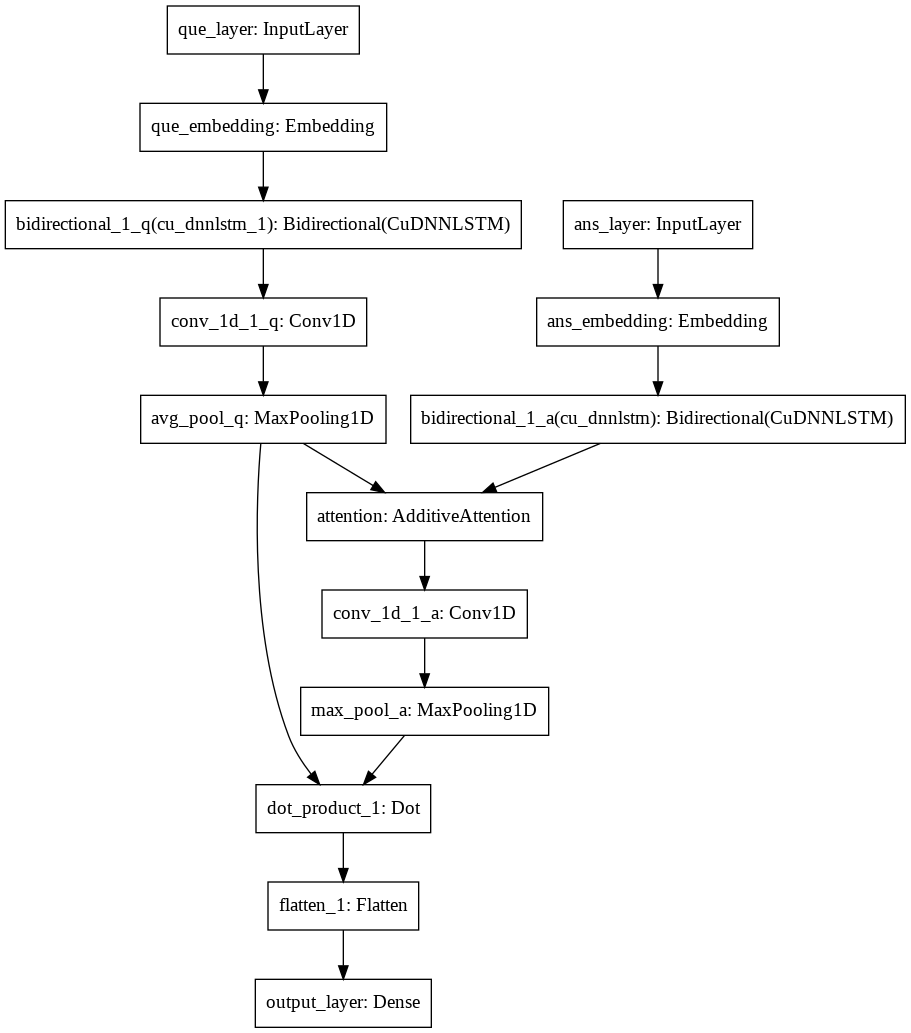

In [0]:
plot_model(model)

In [0]:
n_epochs =  12
batch_size = 1024

log_dir= d+'logs_file/'+"logs3/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#defining callbacks
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1,
                                   batch_size= batch_size, write_grads=True)
es = EarlyStopping(monitor = 'val_loss', mode = 'min', min_delta = 0.001, patience = 5, verbose = 1)
pe = mrr_callback_checkpoint(filepath = model_path+"Model_3.h5",
                            training_data = ([encoded_que_train, encoded_ans_train], y_train),
                            validation_data = ([encoded_que_cv, encoded_ans_cv], y_cv),
                            verbose = 1, save_best_only = True)
#compile the model
model.compile(loss='binary_crossentropy', optimizer = "adam")
# train the model
history = model.fit([encoded_que_train, encoded_ans_train], y_train,
                    validation_data = ([encoded_que_cv, encoded_ans_cv], y_cv),
                    epochs = n_epochs, batch_size = batch_size,
                    callbacks = [es, pe, tensorboard_callback]) # 

Train on 3800000 samples, validate on 100000 samples
Epoch 1/12
3799040/3800000 [============================>.] - ETA: 0s - loss: 0.3120
Epoch 1: Train MRR: 0.47044 and CV MRR: 0.44965
Epoch 00001: val mrr-score improved from -inf to 0.44965, saving model to /content/drive/My Drive/Colab Notebooks/Datasets/Personal Case Study/Search Engine/Models/Model_3.h5
3800000/3800000 [==============================] - 1391s 366us/sample - loss: 0.3120 - val_loss: 0.3080
Epoch 2/12
3799040/3800000 [============================>.] - ETA: 0s - loss: 0.2995
Epoch 2: Train MRR: 0.49818 and CV MRR: 0.47205
Epoch 00002: val mrr-score improved from 0.44965 to 0.47205, saving model to /content/drive/My Drive/Colab Notebooks/Datasets/Personal Case Study/Search Engine/Models/Model_3.h5
3800000/3800000 [==============================] - 1357s 357us/sample - loss: 0.2995 - val_loss: 0.3025
Epoch 3/12
3799040/3800000 [============================>.] - ETA: 0s - loss: 0.2947
Epoch 3: Train MRR: 0.51354 and CV 

In [0]:
print(os.listdir('./logs3/fit'))
log_dir = './logs3/fit/20200129-122932'

['20200129-122932']


In [0]:
%load_ext tensorboard
%tensorboard --logdir {log_dir} 

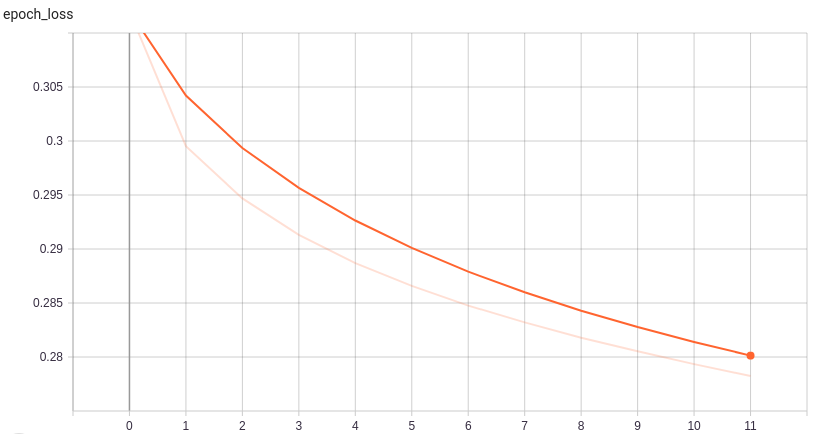

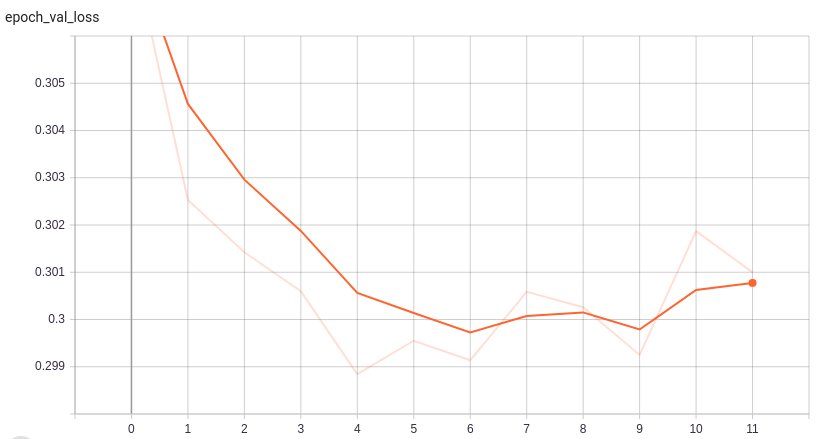

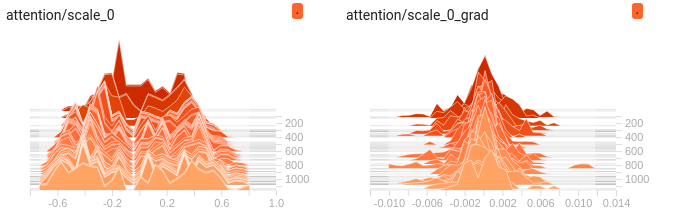

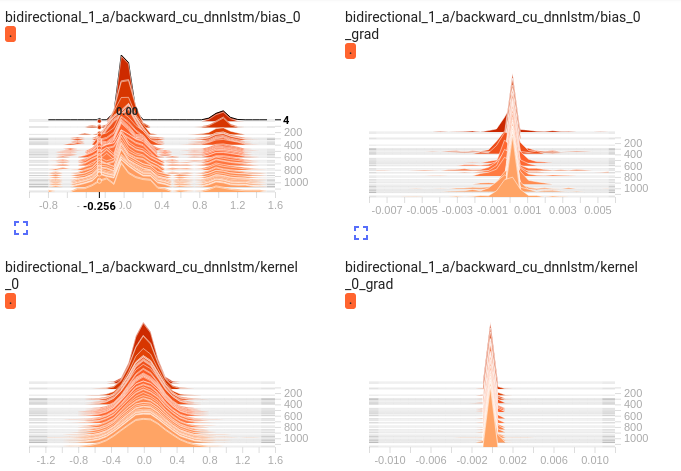

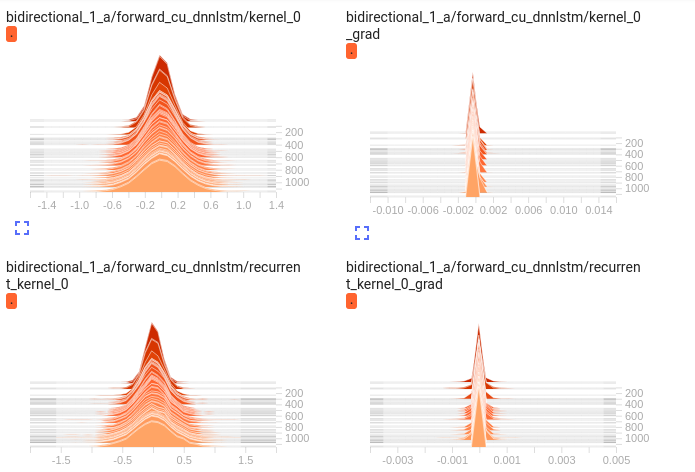

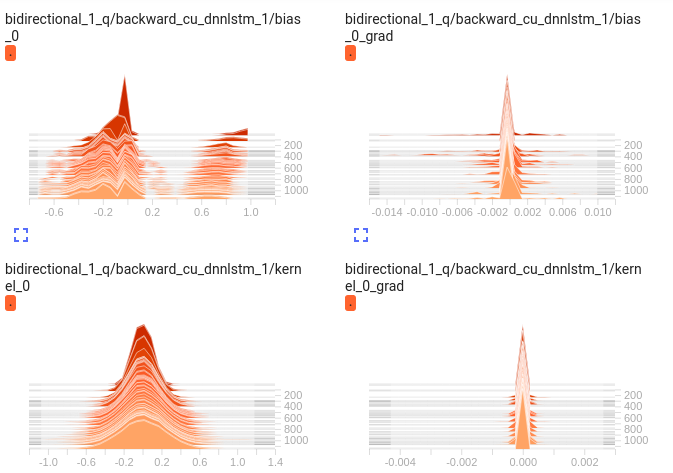

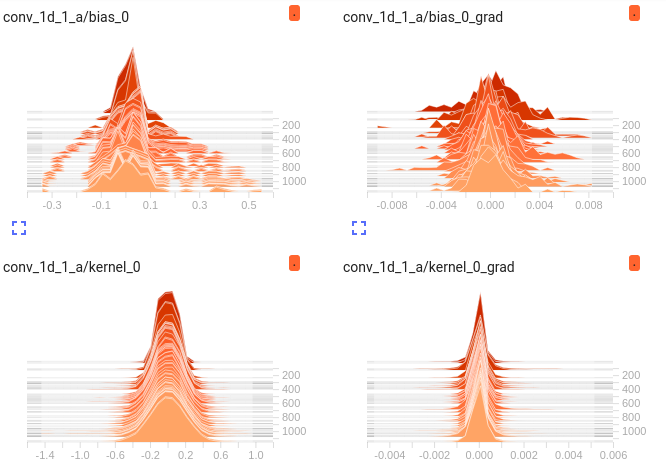

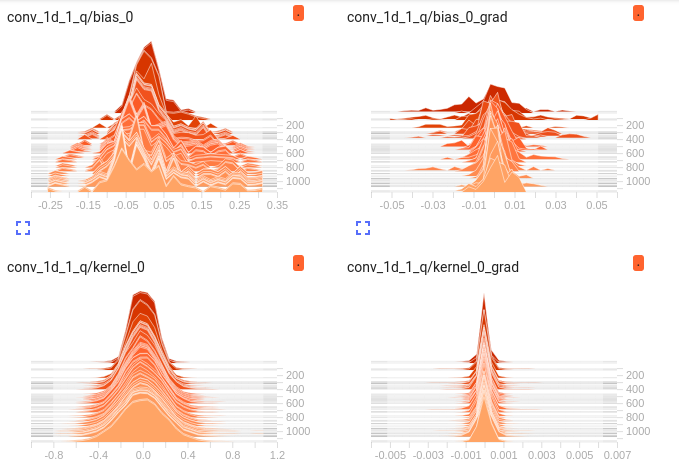

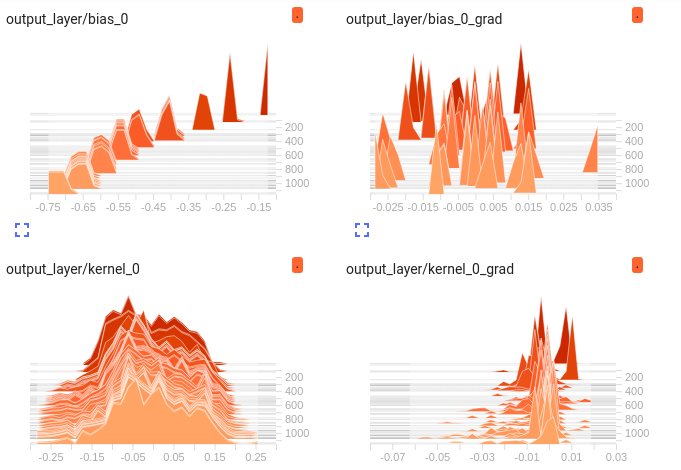

In [3]:
from IPython.display import Image, display
import os

images = os.listdir('./log_screenshots/Model_3')
images.sort()
for image in images:
    display(Image(filename='./log_screenshots/Model_3/'+image))


100000/100000 [==============================] - 7s 69us/sample
For this model:
 Train mrr-score: 0.5340    
 CV mrr-score: 0.4853
 Test mrr-score: 0.4891
                               ******************** For Train data ********************


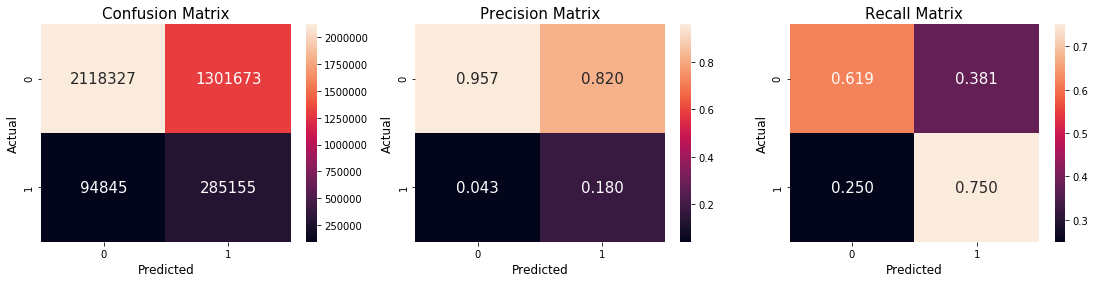

                               ******************** For CV data ********************


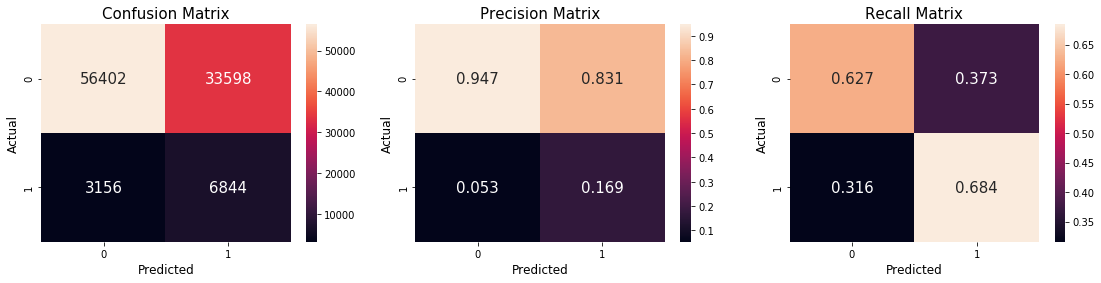

                               ******************** For Test data ********************


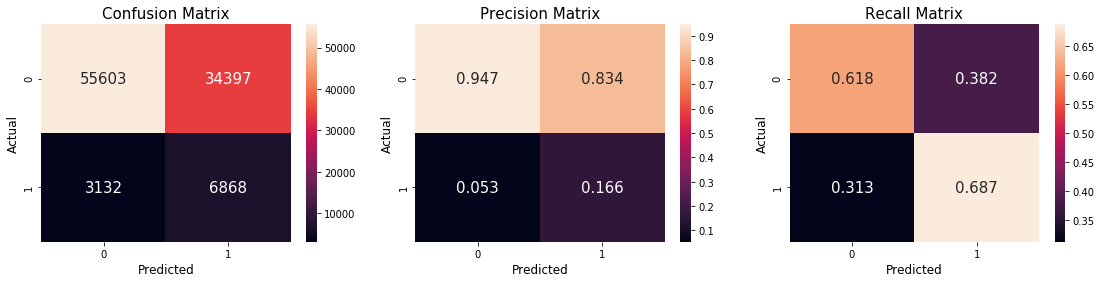

In [0]:
if os.path.isfile(model_path+"Model_3.h5"):
    best_model = create_model_3()
    best_model.load_weights(model_path+"Model_3.h5")
    tr, cv, te = report_model1(best_model,
                               [encoded_que_train, encoded_ans_train],
                               [encoded_que_cv, encoded_ans_cv],
                               [encoded_que_test, encoded_ans_test],
                               batch_size = 1024)
    # model_perf.add_row(["DL (Model-3)", "Word Embedding", tr, cv, te])
else:
    print("Tunned model is not is not in disk. Run above cell.")

### **4.5.5 BERT Model**

Code Reference:

> https://github.com/amaiya/ktrain

>https://nbviewer.jupyter.org/github/amaiya/ktrain/blob/master/tutorials/tutorial-A3-hugging_face_transformers.ipynb

>https://towardsdatascience.com/text-classification-with-hugging-face-transformers-in-tensorflow-2-without-tears-ee50e4f3e7ed

* It uses tensorflow 2.x, so this section of must be run seperately

In [0]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### **4.5.5.1 Data Loading**

In [0]:
import os, time, re, random, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, classification_report

d = "/content/drive/My Drive/Colab Notebooks/Datasets/Personal Case Study/Search Engine/"
model_path = d+"Models/"

df = pd.read_csv(d+"Processed Data/text_processed.csv", low_memory= True)
df = df[['question', 'answer', 'label']].head(500000) # 0.5 million datapoints

df_train = df.iloc[0:300000, :] 
df_cv    = df.iloc[300000:400000, :]
df_test  = df.iloc[400000:, :]

**Functions**

In [0]:
from sklearn.metrics import confusion_matrix

def plot_C_P_R_matrix(y_true, y_pred, name):
    """
    Funtion to plot confusion, precision and recall matrix
    """
    C = confusion_matrix(y_true, y_pred) #for confusion matrix
    # for presion matrix: take the sum column wise, i.e. column normalization
    P = C/C.sum(axis = 0) # it'll have column sum = 1
    #for recall matrix: take the sum row wise, i.e. row normalization
    R = (C.T/C.sum(axis = 1)).T #it'll have row sum = 1

    fig, (ax1, ax2, ax3)  = plt.subplots(1,3, figsize= (19,4))

    #https://seaborn.pydata.org/generated/seaborn.heatmap.html
    sns.heatmap(C, annot = True, fmt = 'd', annot_kws={"size":15}, ax = ax1)
    ax1.set_title("Confusion Matrix", fontsize = 15)
    ax1.set_xlabel("Predicted", fontsize = 12)
    ax1.set_ylabel("Actual", fontsize = 12)

    sns.heatmap(P, annot = True, fmt = '.3f', annot_kws={"size":15}, ax = ax2)
    ax2.set_title("Precision Matrix", fontsize = 15)
    ax2.set_xlabel("Predicted", fontsize = 12)
    ax2.set_ylabel("Actual", fontsize = 12)

    sns.heatmap(R, annot = True, fmt = '.3f', annot_kws={"size":15}, ax = ax3)
    ax3.set_title("Recall Matrix", fontsize = 15)
    ax3.set_xlabel("Predicted", fontsize = 12)
    ax3.set_ylabel("Actual", fontsize = 12)

    plt.show()

########################################################################################
#######################    function to plot Confusion matrix     #######################
########################################################################################
def plot_confusion_matrix(y_train, y_train_pred, y_cv, y_cv_pred, y_test, y_test_pred, thres):
    """
    funtion to plot the precison, recall and confusion matrix for train, cv and test data
    """
    tr_pred = np.where(y_train_pred >= thres, 1, 0)
    cv_pred = np.where(y_cv_pred >= thres, 1, 0)
    te_pred = np.where(y_test_pred >= thres, 1, 0)   

    print(" "*30, "*"*20, "For Train data", "*"*20)
    plot_C_P_R_matrix(y_train.values.flatten(), tr_pred, name = "Train")

    print(" "*30, "*"*20, "For CV data", "*"*20)
    plot_C_P_R_matrix(y_cv.values.flatten(), cv_pred, name = "CV")

    print(" "*30, "*"*20, "For Test data", "*"*20)
    plot_C_P_R_matrix(y_test.values.flatten(), te_pred, name = "Test")

from sklearn.metrics import label_ranking_average_precision_score
def get_mrr(y_true, y_pred):
    """
    to calcuate the mrr.
    it take the y_true and y_pred and make list of lists such that
    for each question ten answer result in list.
    """
    y_true = np.array([y_true[i*10:(i+1)*10] for i in range(len(y_true)//10)])
    y_pred = np.array([y_pred[i*10:(i+1)*10] for i in range(len(y_pred)//10)])
    return label_ranking_average_precision_score(y_true, y_pred)

#### **4.5.5.2 Installing/Importing Required libraries**

In [0]:
!pip3 install -q tensorflow_gpu>=2.0

import tensorflow as tf
print(tf.__version__)

ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.1.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorboard 2.1.0 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.0 which is incompatible.
2.1.0


In [0]:
!pip3 install -q ktrain

     |████████████████████████████████| 102kB 2.8MB/s 
     |████████████████████████████████| 6.7MB 10.5MB/s 
     |████████████████████████████████| 1.0MB 45.2MB/s 
     |████████████████████████████████| 245kB 55.0MB/s 
     |████████████████████████████████| 1.8MB 45.7MB/s 
     |████████████████████████████████| 481kB 46.1MB/s 
     |████████████████████████████████| 3.1MB 38.5MB/s 
     |████████████████████████████████| 870kB 59.9MB/s 
     |████████████████████████████████| 1.0MB 46.1MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


#### **4.5.5.3 Model Creattion and Training**

In [0]:
import ktrain
from ktrain import text

using Keras version: 2.2.4-tf


In [0]:
# definig the model name
MODEL_NAME = 'distilbert-base-uncased'

# getting the Transformer
t = text.Transformer(MODEL_NAME, maxlen = 200, classes=[0,1])

# pre-prcoessing the data for training the model 
trn = t.preprocess_train(list(df_train['question'] + ['[SEP]'] + df_train['answer']),
                         df_train['label'].values)
val = t.preprocess_test(list(df_cv['question'] + ['[SEP]'] + df_cv['answer']),
                        df_cv['label'].values)

model = t.get_classifier()

# creating the batchs of data created in above lines
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=64)

using Keras version: 2.2.4-tf
preprocessing train...
language: en
train sequence lengths:
	mean : 40
	95percentile : 71
	99percentile : 87


preprocessing test...
language: en
test sequence lengths:
	mean : 37
	95percentile : 65
	99percentile : 81


simulating training for different learning rates... this may take a few moments...
Train for 9375 steps
9375/9375 [==============================] - 6129s 654ms/step - loss: 0.3614 - accuracy: 0.8940


done.


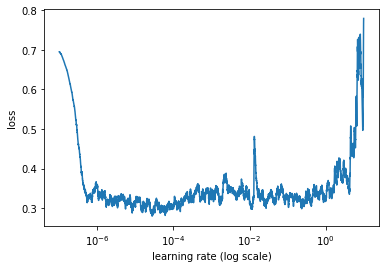

In [0]:
# to visualize and select the best learning rate
learner.lr_find(show_plot=True, max_epochs=1)  

In [0]:
# model trainig
learner.fit_onecycle(1*10**(-4), 2)



begin training using onecycle policy with max lr of 0.0001...
Train for 4688 steps, validate for 1563 steps
Epoch 1/2
4688/4688 [==============================] - 6860s 1s/step - loss: 0.2945 - accuracy: 0.8998 - val_loss: 0.2939 - val_accuracy: 0.9000
Epoch 2/2
4688/4688 [==============================] - 6806s 1s/step - loss: 0.2690 - accuracy: 0.9002 - val_loss: 0.2836 - val_accuracy: 0.9002


#### **4.5.5.4 Model Saving and Predcition**

In [0]:
#save the predictor
predictor = ktrain.get_predictor(learner.model, preproc=t)
predictor.save(model_path+'bert/')

In [0]:
#load the trained model
predictor = ktrain.load_predictor(model_path+'bert/')

In [0]:
# creating the dataframe to store the predictions
tr_pred_df = pd.DataFrame()
cv_pred_df = pd.DataFrame()
te_pred_df = pd.DataFrame()

In [0]:
# prediction for train/cv/test dataset
tr_pred_df['actual_label'] = df_train['label']
y_tr_pred_proba = predictor.predict_proba(list(df_train['question'] + ['[SEP]'] + df_train['answer']))
tr_pred_df['class0_proba'] = y_tr_pred_proba[:,0]
tr_pred_df['class1_proba'] = y_tr_pred_proba[:,1]

# save the prediction in disk
tr_pred_df.to_csv(d+'train_pred.csv', index=False)

In [0]:
cv_pred_df['actual_label'] = df_cv['label']
y_cv_pred_proba = predictor.predict_proba(list(df_cv['question'] + ['[SEP]'] + df_cv['answer']))
cv_pred_df['class0_proba'] = y_cv_pred_proba[:,0]
cv_pred_df['class1_proba'] = y_cv_pred_proba[:,1]

# save the prediction in disk
cv_pred_df.to_csv(d+'cv_pred.csv', index=False)

In [0]:
te_pred_df['actual_label'] = df_test['label']
y_te_pred_proba = predictor.predict_proba(list(df_test['question'] + ['[SEP]'] + df_test['answer']))
te_pred_df['class0_proba'] = y_te_pred_proba[:,0]
te_pred_df['class1_proba'] = y_te_pred_proba[:,1]

# save the prediction in disk
te_pred_df.to_csv(d+'test_pred.csv', index=False)

**Load the data if again runining the notebook**

In [0]:
te_pred_df.head(10)

actual_label  class0_proba  class1_proba
400000             0      0.749009      0.250991
400001             0      0.955313      0.044687
400002             1      0.794842      0.205158
400003             0      0.865639      0.134361
400004             0      0.830737      0.169263
400005             0      0.901381      0.098619
400006             0      0.785977      0.214023
400007             0      0.733977      0.266023
400008             0      0.863866      0.136134
400009             0      0.958681      0.041319

#### **4.5.5.5 Model Performance**

In [0]:
tr_mrr = get_mrr(tr_pred_df['actual_label'].values, tr_pred_df['class1_proba'].values)
cv_mrr = get_mrr(cv_pred_df['actual_label'].values, cv_pred_df['class1_proba'].values)
te_mrr = get_mrr(te_pred_df['actual_label'].values, te_pred_df['class1_proba'].values)
print('Train MRR = {:.4f}\nCV MRR: {:.4f}\nTest MRR: {:.4f}'.format(tr_mrr, cv_mrr, te_mrr))

Train MRR = 0.7544
CV MRR: 0.5607
Test MRR: 0.6018


In [0]:
# let's decide the threshold value to visulaize the confuion matrix
# f1-score will be used to pick the best threshold
thresholds = [i/20 for i in range(1,21)]
tr_f1, cv_f1 = [], []
for thes in thresholds:
    tr_f1.append(f1_score(tr_pred_df['actual_label'].values, 
                          np.where(tr_pred_df['class1_proba'].values>=thes,1,0)))
    cv_f1.append(f1_score(cv_pred_df['actual_label'].values, 
                          np.where(cv_pred_df['class1_proba'].values>=thes,1,0)))

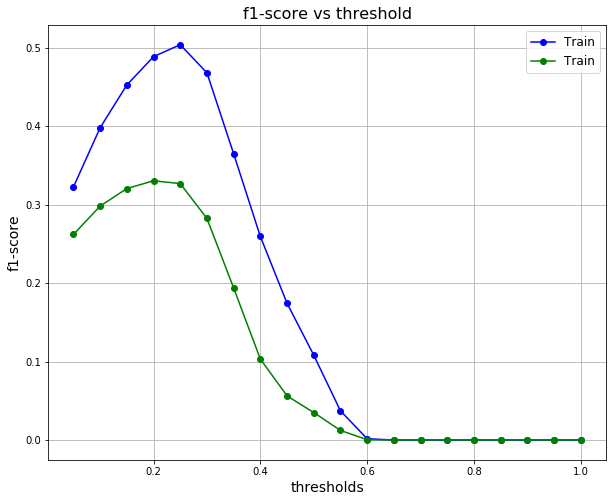

In [0]:
plt.figure(figsize=(10,8))
plt.plot(thresholds, tr_f1, 'bo-', label='Train')
plt.plot(thresholds, cv_f1, 'go-', label='Train')
plt.title('f1-score vs threshold', fontsize=16)
plt.xlabel('thresholds', fontsize=14)
plt.ylabel('f1-score', fontsize=14)
plt.legend(fontsize=12)
plt.grid(1)
plt.show()

                               ******************** For Train data ********************


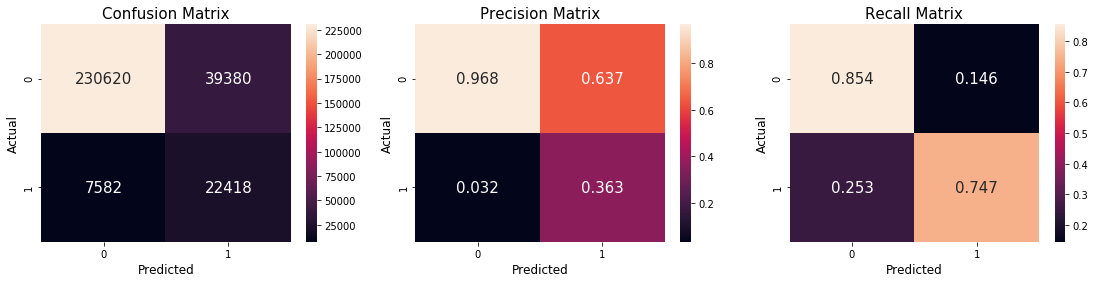

                               ******************** For CV data ********************


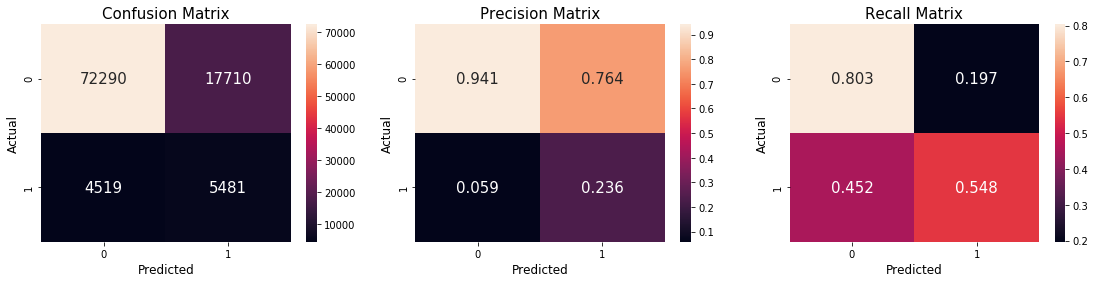

                               ******************** For Test data ********************


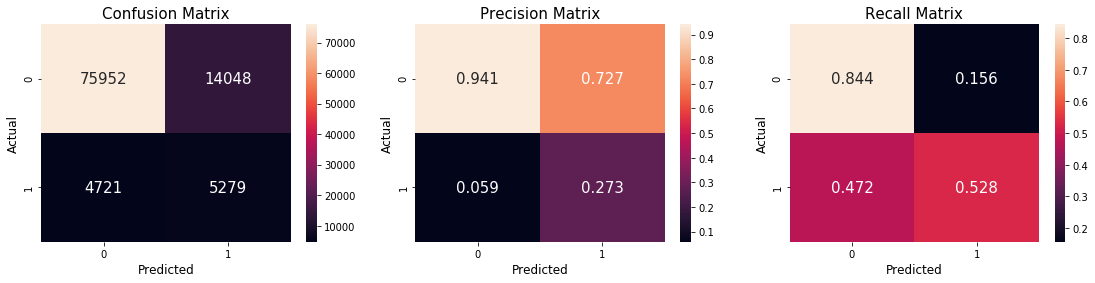

In [0]:
plot_confusion_matrix(tr_pred_df['actual_label'], tr_pred_df['class1_proba'],
                      cv_pred_df['actual_label'], cv_pred_df['class1_proba'], 
                      te_pred_df['actual_label'], te_pred_df['class1_proba'], thres=0.2)

In [0]:
print(classification_report(te_pred_df['actual_label'], np.where(te_pred_df['class1_proba'].values>=0.2,1,0)))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89     90000
           1       0.27      0.53      0.36     10000

    accuracy                           0.81    100000
   macro avg       0.61      0.69      0.63    100000
weighted avg       0.87      0.81      0.84    100000



# **5. Conclusion**

|    Model Name  |   Vectorizer   | Train (MRR) | CV (MRR) | Test (MRR) |
|----------------|----------------|-------------|----------|------------|
| BERT           | -----          |   0.7544    | 0.5607   | 0.6018     |
| DL (Model- 2)  | Word Embedding |   0.5462    | 0.4983   | 0.4926     |
| DL (Model-3)   | Word Embedding |   0.5340    | 0.4853   | 0.4891     |
| DL (Model-1)   | Word Embedding |   0.4808    | 0.4390   | 0.4411     |
|    GBDT        |     tfidf      |   0.5085    | 0.4257   |  0.4114    |
| Logistic Regression | TF-IDF    |   0.4273    | 0.4035   | 0.3876     |
|    Decision Tree    | tfidf     |  0.4412     | 0.3081   | 0.3042     |

**Summary**
* The dataset has around 5 million datapoints. There are five columns in dataset. Only three of these columns are required in our case. 
* Then text processing was done and dropped the rows where there was no question/answer. There were some rows where `null` was present as `string`, so it was also removed. 
* Using text data 13 features were designed. EDA on these features was done which showed that they don't play much role in classifying the labels. But these features were added to train the model.
* For **Classical ML models** **2 million** out of **5 million** datapoints were taken for training, validation and testing. The dataset was split in 80%-10%-10% ratio. First 80% of dataset was taken for training, next 10% for validation and next 10% for testing.
* In ML: logistic regression, decision tree and GBDT models were trained using TF-IDF (bi-gram). Out of all these ML model **GBDT** was giving best performance.
* After training few models, it was found that model was overfitting. So **4 million** datapoints is selected for DL models. 
* First 95% for training, next 5% for validation and next 5% for testing. 
* In DL 3 models were trained. Out of these DL models second model which is based on **LSTM** gave the best performance.
* But the **BERT** model outperforms all other models. Training **BERT** model is very expensive. So only **0.5 million** data points were taken for **BERT** model.
* **BERT** gave **CV-mrr = 0.56** and **test mrr=0.60**
